In [417]:
# generic modules
import datetime, os
import itertools
import time
import pickle

# append working folder
import sys
# working_folder = './gdrive/My Drive/Teaching/CS4305TU Applied Machine Learning/SWMM/'
# sys.path.append(working_folder)


# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
# import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import backend as K

# sklearn helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import scipy
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib

In [418]:
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time_lag.csv")
df_p_t_state = pd.read_csv("../data/raw/processed/state_tp_time.csv")
df = df_p_t[['date','tweet_count', 'protest_count']]
df_state = df_p_t_state[['date','tweet_count', 'protest_count', "state"]]
df['state'] = 'USA'
df = pd.concat([df_state, df])
df.date = pd.to_datetime(df.date)

df.index = df.date
df = df.drop("date", axis=1)

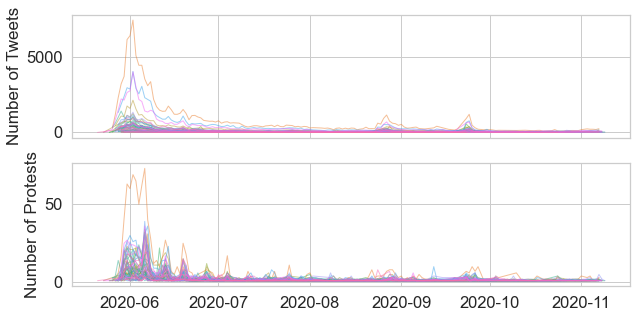

In [3]:
# tweets_geo = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")
sns.set(style ="whitegrid", font_scale=1.5)
# preprocess protest and tweet data
# tweets_geo['created_at'] = pd.to_datetime(tweets_geo['created_at'])
# tweets_geo['tweet_count'] = 1
# tweets_geo['created_at_day'] = pd.to_datetime(tweets_geo['created_at'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

# df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'], format='%Y-%m-%d')
fig, ax = plt.subplots(2,1, figsize=(10,5))
g1 = sns.lineplot(ax = ax[0], data = df[df['state']!="USA"], x = 'date', y = 'tweet_count', linewidth = 1, hue="state", alpha=0.5)
g2 = sns.lineplot(ax = ax[1], data = df[df['state']!="USA"], x = 'date', y = 'protest_count', linewidth = 1, hue="state", alpha=0.5)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("Number of Tweets", fontsize=17)
ax[1].set_ylabel("Number of Protests", fontsize=17)
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)
g1.legend_.remove()
g2.legend_.remove()

# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

# ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
# ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

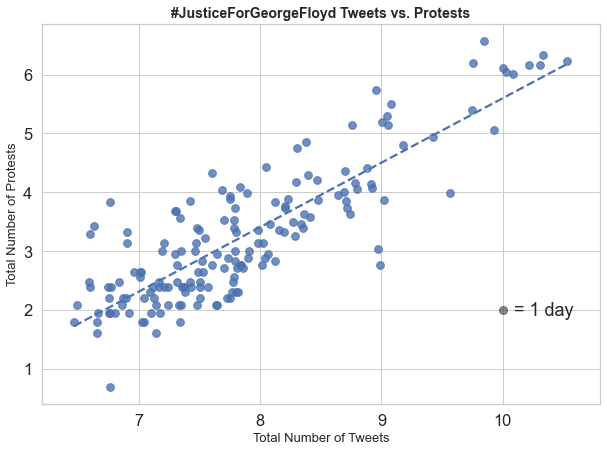

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.852
R^2 score = 0.726


In [4]:
fig, ax = plt.subplots(figsize=(10,7))

X = np.log(df[df['state']=="USA"]['tweet_count'][:, None])
y = np.log(df[df['state']=="USA"]['protest_count'][:, None])

# ax.set_yscale("log")
# ax.set_xscale("log")
ax = sns.regplot(data = df[df['state']=="USA"], x = X, y = y, scatter_kws={"s": 60}, ci=False)
# ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

ax.set(xlim=(6.2, 10.8))
# ax.set_xlim(2000,)

# ax.set_xlim(auto=True)

ax.lines[0].set_linestyle("--")

ax.set_xlabel("Total Number of Tweets", fontsize=13)
ax.set_ylabel("Total Number of Protests", fontsize=13)
ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

# regression metrics
slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

# annotations
style = dict(size=11)
# ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
# ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

# legend
ax.plot(10, 2, 'o',
        ms=8, mec='k', color="k", alpha=0.5)

ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


plt.show()

print("-"*110)
print(f"Pearson Correlation = {r_value.round(3)}")
print(f"R^2 score = {(r_value**2).round(3)}")

## Digital/physical activism index (county)

In [419]:
df_p_t_county = pd.read_csv("../data/raw/processed/counties_pt_time.csv", dtype={"GEOID": str})
df_p_t_county.date = pd.to_datetime(df_p_t_county.date)

In [421]:
# group county data by week
df_p_t_county['date_w'] = pd.to_datetime(df_p_t_county['date']) - pd.to_timedelta(7, unit='d')
# df_p_t_w_county = df_p_t_county.groupby(['GEOID', pd.Grouper(key='date_w', freq='W-MON')])[['protest_count', 'tweet_count']].sum().reset_index().sort_values('date_w')
df_p_t_w_county = df_p_t_county.groupby(['GEOID', pd.Grouper(key='date_w', freq='W-MON')]).agg({"protest_count":"sum","tweet_count":"sum", "POP_ESTIMATE_2019":"mean"})[['protest_count', 'tweet_count', "POP_ESTIMATE_2019"]].reset_index().sort_values('date_w')

In [189]:
# len(df_p_t_county.GEOID.unique())

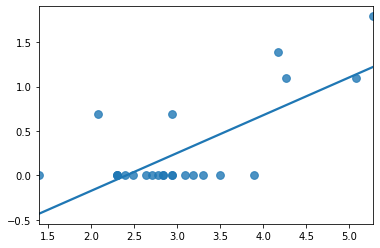

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.7287000160436514
R^2 score = 0.5310037133820178


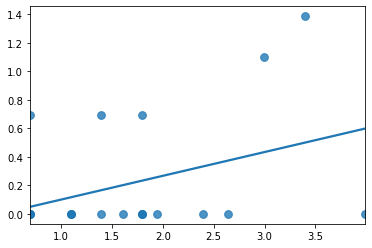

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.36944279237786404
R^2 score = 0.13648797683995356


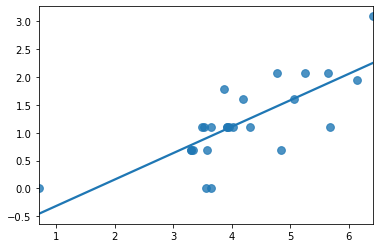

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.759991118663333
R^2 score = 0.5775865004471443


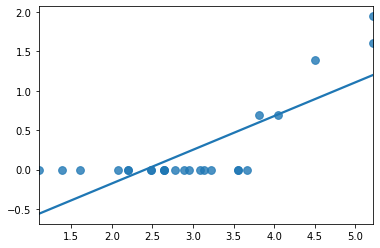

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.7923014623492797
R^2 score = 0.6277416072408071


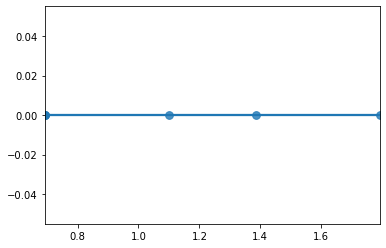

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.0
R^2 score = 0.0


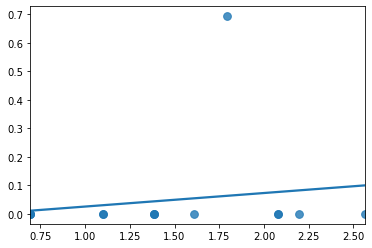

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.1629245291194438
R^2 score = 0.02654440218879249


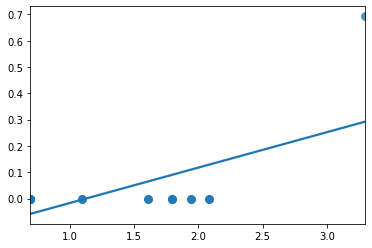

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.6253985307042982
R^2 score = 0.391123322207095


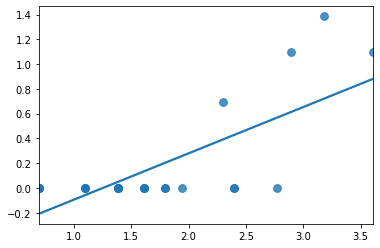

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.7281792595594162
R^2 score = 0.5302450340524997


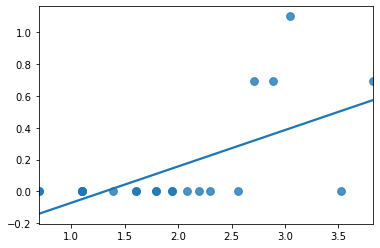

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.6248631918585191
R^2 score = 0.3904540085396165


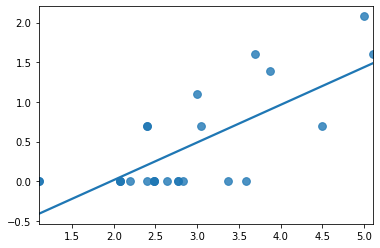

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.7376059153160757
R^2 score = 0.5440624863092658


In [111]:
# df_p_t_w_county = df_p_t_w_county.replace(np.NaN, "0")
# df_p_t_w_county['protest_count'] = pd.to_numeric(df_p_t_w_county['protest_count'])
for county in df_p_t_w_county.sample(10).GEOID.unique():

#     data = df_p_t_county.replace(np.NaN, "0")[(df_p_t_county['GEOID']==county)&(df_p_t_county['tweet_count'].isna()==False)&(df_p_t_county['protest_count'].isna()==False)]
#     data = df_p_t_w_county[(df_p_t_w_county['GEOID']==county)&(df_p_t_w_county['tweet_count']!=0)&(df_p_t_w_county['protest_count']!=0)]
    data = df_p_t_w_county[(df_p_t_w_county['GEOID']==county)]
    X = np.log1p(data['tweet_count'][:, None])
    y = np.log1p(data['protest_count'][:, None])

    # ax.set_yscale("log")
    # ax.set_xscale("log")
    ax = sns.regplot(x = X, y = y, scatter_kws={"s": 60}, ci=False)
    # ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

#     ax.set(xlim=(6.2, 10.8))
    # ax.set_xlim(2000,)

    # ax.set_xlim(auto=True)

#     ax.lines[0].set_linestyle("--")

#     ax.set_xlabel("Total Number of Tweets", fontsize=13)
#     ax.set_ylabel("Total Number of Protests", fontsize=13)
#     ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

    # regression metrics
    slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

    # annotations
#     style = dict(size=11)
    # ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
    # ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

    # legend
#     ax.plot(10, 2, 'o',
#             ms=8, mec='k', color="k", alpha=0.5)

#     ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


    plt.show()

    print("-"*110)
    print(f"Pearson Correlation = {r_value}")
    print(f"R^2 score = {(r_value**2)}")

#### index data-set for weekly county values

In [725]:
# df_p_t_w_county = df_p_t_w_county.replace(np.NaN, "0")
# df_p_t_w_county['protest_count'] = pd.to_numeric(df_p_t_w_county['protest_count'])
slopes = []
intercepts = []
r_values = []
r2_values = []
p_values = []
std_errs = []
counties = []
num_dtpts = []
pops = []

# for county in df_p_t_w_county.sample(10).GEOID.unique():
for county in df_p_t_w_county.GEOID.unique():

#     data = df_p_t_county.replace(np.NaN, "0")[(df_p_t_county['GEOID']==county)&(df_p_t_county['tweet_count'].isna()==False)&(df_p_t_county['protest_count'].isna()==False)]
#     data = df_p_t_w_county[(df_p_t_w_county['GEOID']==county)&(df_p_t_w_county['tweet_count']!=0)&(df_p_t_w_county['protest_count']!=0)]
    data = df_p_t_w_county[(df_p_t_w_county['GEOID']==county)]
    pop = data['POP_ESTIMATE_2019'].mean()
    X = np.log1p(data['tweet_count'][:, None])
    y = np.log1p(data['protest_count'][:, None])
    
    dtpts = len(data)
    # regression metrics
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

#     print("-"*110)
#     print(f"Pearson Correlation = {r_value}")
#     print(f"R^2 score = {(r_value**2)}")
    
    slopes.append(slope)
    intercepts.append(intercept)
    r_values.append(r_value)
    r2_values.append(r_value**2)
    p_values.append(p_value)
    std_errs.append(std_err)
    counties.append(county)
    num_dtpts.append(dtpts)
    pops.append(pop)
    
corrs_dict = {"GEOID": counties, "slope": slopes, "intercept": intercepts, "r_value": r_values, "r2_value": r2_values, "p_value": p_values, "std_err": std_errs, "num_dtpts":num_dtpts, "pop":pops}
county_corrs_df = pd.DataFrame.from_dict(corrs_dict)

In [729]:
from functools import reduce

counties = gpd.read_file("../data/raw/us_admin/tl_2017_us_county.shp")
counties_edu = pd.read_excel("../data/raw/us_admin/Education.xls", skiprows = [0,1,2,3],converters={'FIPS Code': str})[['FIPS Code', 'Percent of adults with less than a high school diploma, 2015-19']].rename(columns={"FIPS Code":"GEOID"})
counties_pov = pd.read_excel("../data/raw/us_admin/PovertyEstimates.xls", skiprows = [0,1,2,3],converters={'FIPStxt': str})[['FIPStxt', 'PCTPOVALL_2019']].rename(columns={"FIPStxt":"GEOID"})

counties_vars = [counties, counties_edu, counties_pov, county_corrs_df]

county_corrs_df = reduce(lambda left,right: pd.merge(left,right,on='GEOID'), counties_vars)
# county_corrs_df = pd.merge(county_corrs_df, counties)
county_corrs_df['pop_den'] = county_corrs_df['pop']/(county_corrs_df['ALAND']+county_corrs_df['AWATER'])*100000

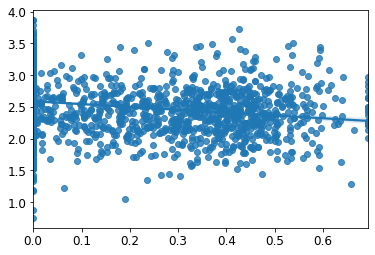

In [733]:
var = 'Percent of adults with less than a high school diploma, 2015-19'

X = np.log1p(county_corrs_df['r2_value'][:, None])
y = np.log1p(county_corrs_df[var][:, None])

sns.regplot( x=X, y = y)

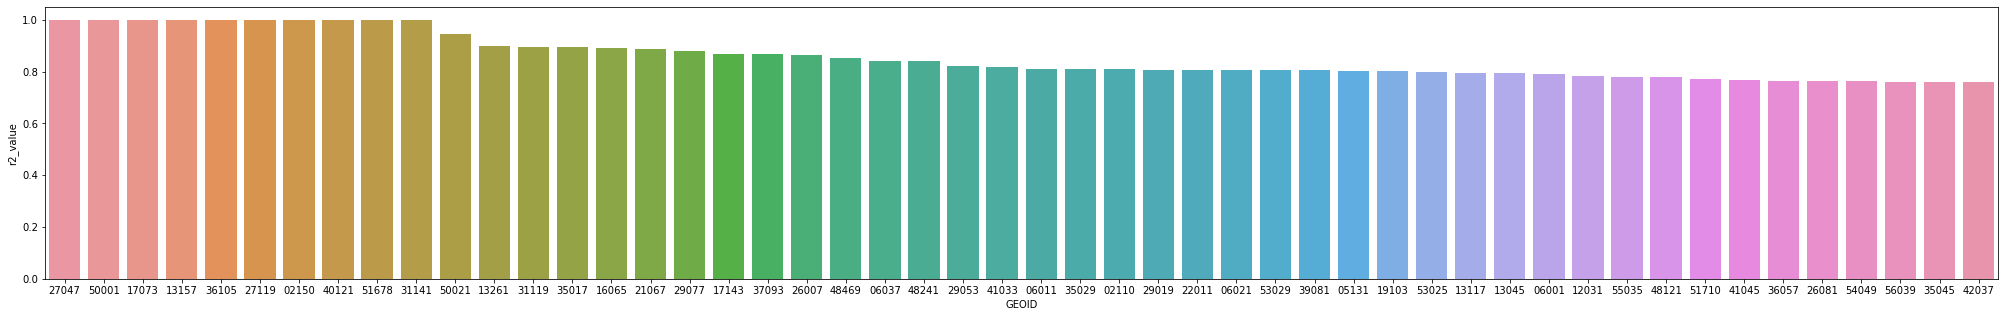

In [178]:
fig, ax = plt.subplots(figsize=(35, 5))
ax = sns.barplot(data = county_corrs_df[(county_corrs_df['r2_value']!=0)&(county_corrs_df['num_dtpts']>=4)].sort_values("r2_value", ascending=False).head(50), x="GEOID", y='r2_value')

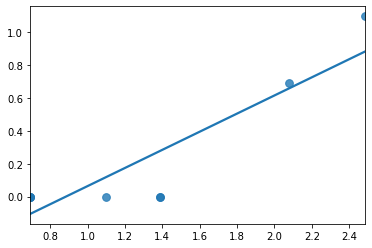

In [180]:
data = df_p_t_w_county[(df_p_t_w_county['GEOID']=="39081")]
X = np.log1p(data['tweet_count'][:, None])
y = np.log1p(data['protest_count'][:, None])

# ax.set_yscale("log")
# ax.set_xscale("log")
ax = sns.regplot(x = X, y = y, scatter_kws={"s": 60}, ci=False)

In [184]:
county_corrs_df.to_csv("../data/raw/processed/county_corrs_df.csv")

In [723]:
county_corrs_df = pd.read_csv("../data/raw/processed/county_corrs_df.csv", dtype={'GEOID': object})

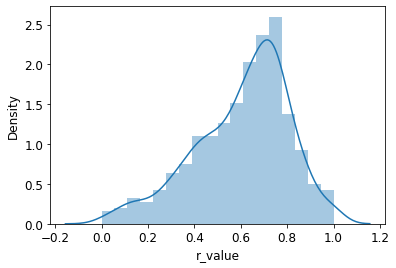

In [712]:
sns.distplot(county_corrs_df[county_corrs_df['r_value']>0]['r_value'])

In [199]:
df_p_t_w_county.to_csv("../data/raw/processed/counties_pt_w_time.csv")

#### index data-set for daily county values

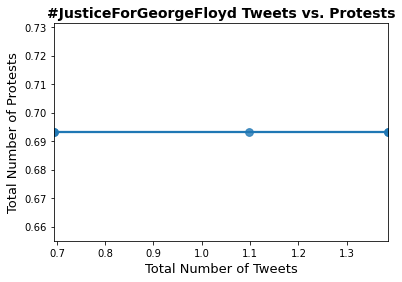

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.0
R^2 score = 0.0


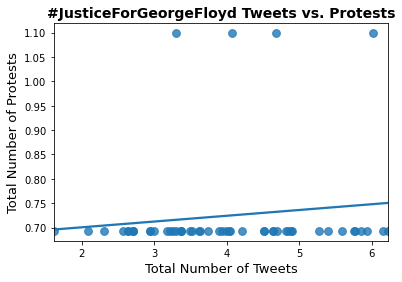

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.12679343044557675
R^2 score = 0.01607657400415731


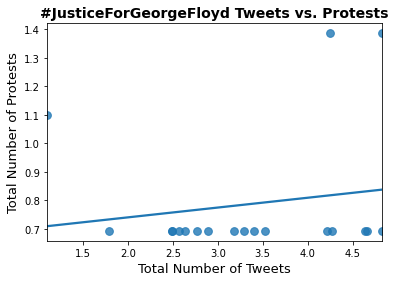

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.16058768897347714
R^2 score = 0.02578840584984223


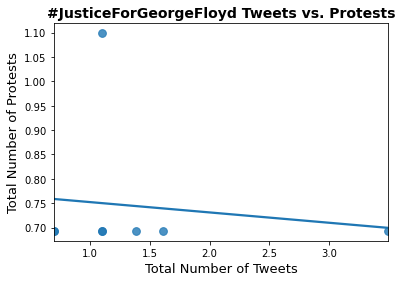

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = -0.13338917517104615
R^2 score = 0.017792672052812035


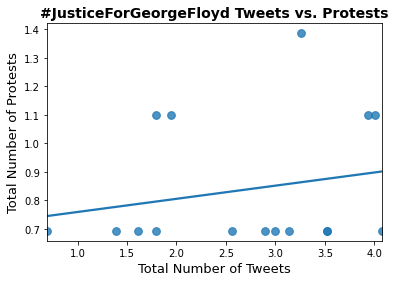

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.20792597310182295
R^2 score = 0.04323321029034


ValueError: Inputs must not be empty.

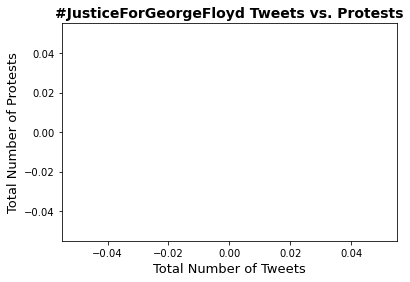

In [68]:
df_p_t_county = df_p_t_county.replace(np.NaN, "0")
df_p_t_county['protest_count'] = pd.to_numeric(df_p_t_county['protest_count'])
for county in df_p_t_county.sample(10).GEOID.unique():

#     data = df_p_t_county.replace(np.NaN, "0")[(df_p_t_county['GEOID']==county)&(df_p_t_county['tweet_count'].isna()==False)&(df_p_t_county['protest_count'].isna()==False)]
    data = df_p_t_county[(df_p_t_county['GEOID']==county)&(df_p_t_county['tweet_count']!=0)&(df_p_t_county['protest_count']!=0)]
    X = np.log1p(data['tweet_count'][:, None])
    y = np.log1p(data['protest_count'][:, None])

    # ax.set_yscale("log")
    # ax.set_xscale("log")
    ax = sns.regplot(x = X, y = y, scatter_kws={"s": 60}, ci=False)
    # ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

#     ax.set(xlim=(6.2, 10.8))
    # ax.set_xlim(2000,)

    # ax.set_xlim(auto=True)

#     ax.lines[0].set_linestyle("--")

    ax.set_xlabel("Total Number of Tweets", fontsize=13)
    ax.set_ylabel("Total Number of Protests", fontsize=13)
    ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

    # regression metrics
    slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

    # annotations
    style = dict(size=11)
    # ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
    # ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

    # legend
#     ax.plot(10, 2, 'o',
#             ms=8, mec='k', color="k", alpha=0.5)

#     ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


    plt.show()

    print("-"*110)
    print(f"Pearson Correlation = {r_value}")
    print(f"R^2 score = {(r_value**2)}")

In [40]:
np.log(data['protest_count'])

1145     1
1146     1
1147     1
1148     2
1149     1
        ..
16713    0
16714    0
16715    0
16716    0
16717    0
Name: protest_count, Length: 127, dtype: object

## Correlated Time Series Analysis

In [ ]:
df_p_t_state = pd.read_csv("../data/raw/processed/state_tp_time.csv")

In [35]:
len(df_p_t_state)

3121

In [37]:
len(df_rs)

7735

In [48]:
import warnings
warnings.filterwarnings("ignore")

# df['tweet_count'] = scaler.fit_transform(df[['tweet_count']])
# df['protest_count'] = scaler.fit_transform(df[['protest_count']])

df_rs = df.groupby('state').resample('D').mean().reset_index().set_index("date")
df_rs['tweet_count'], df_rs['protest_count'] = df_rs['tweet_count'].interpolate(), df_rs['protest_count'].interpolate()

In [47]:
# ADD LAGS
df_rs.to_csv("../data/raw/processed/state_tp_time_rs.csv")

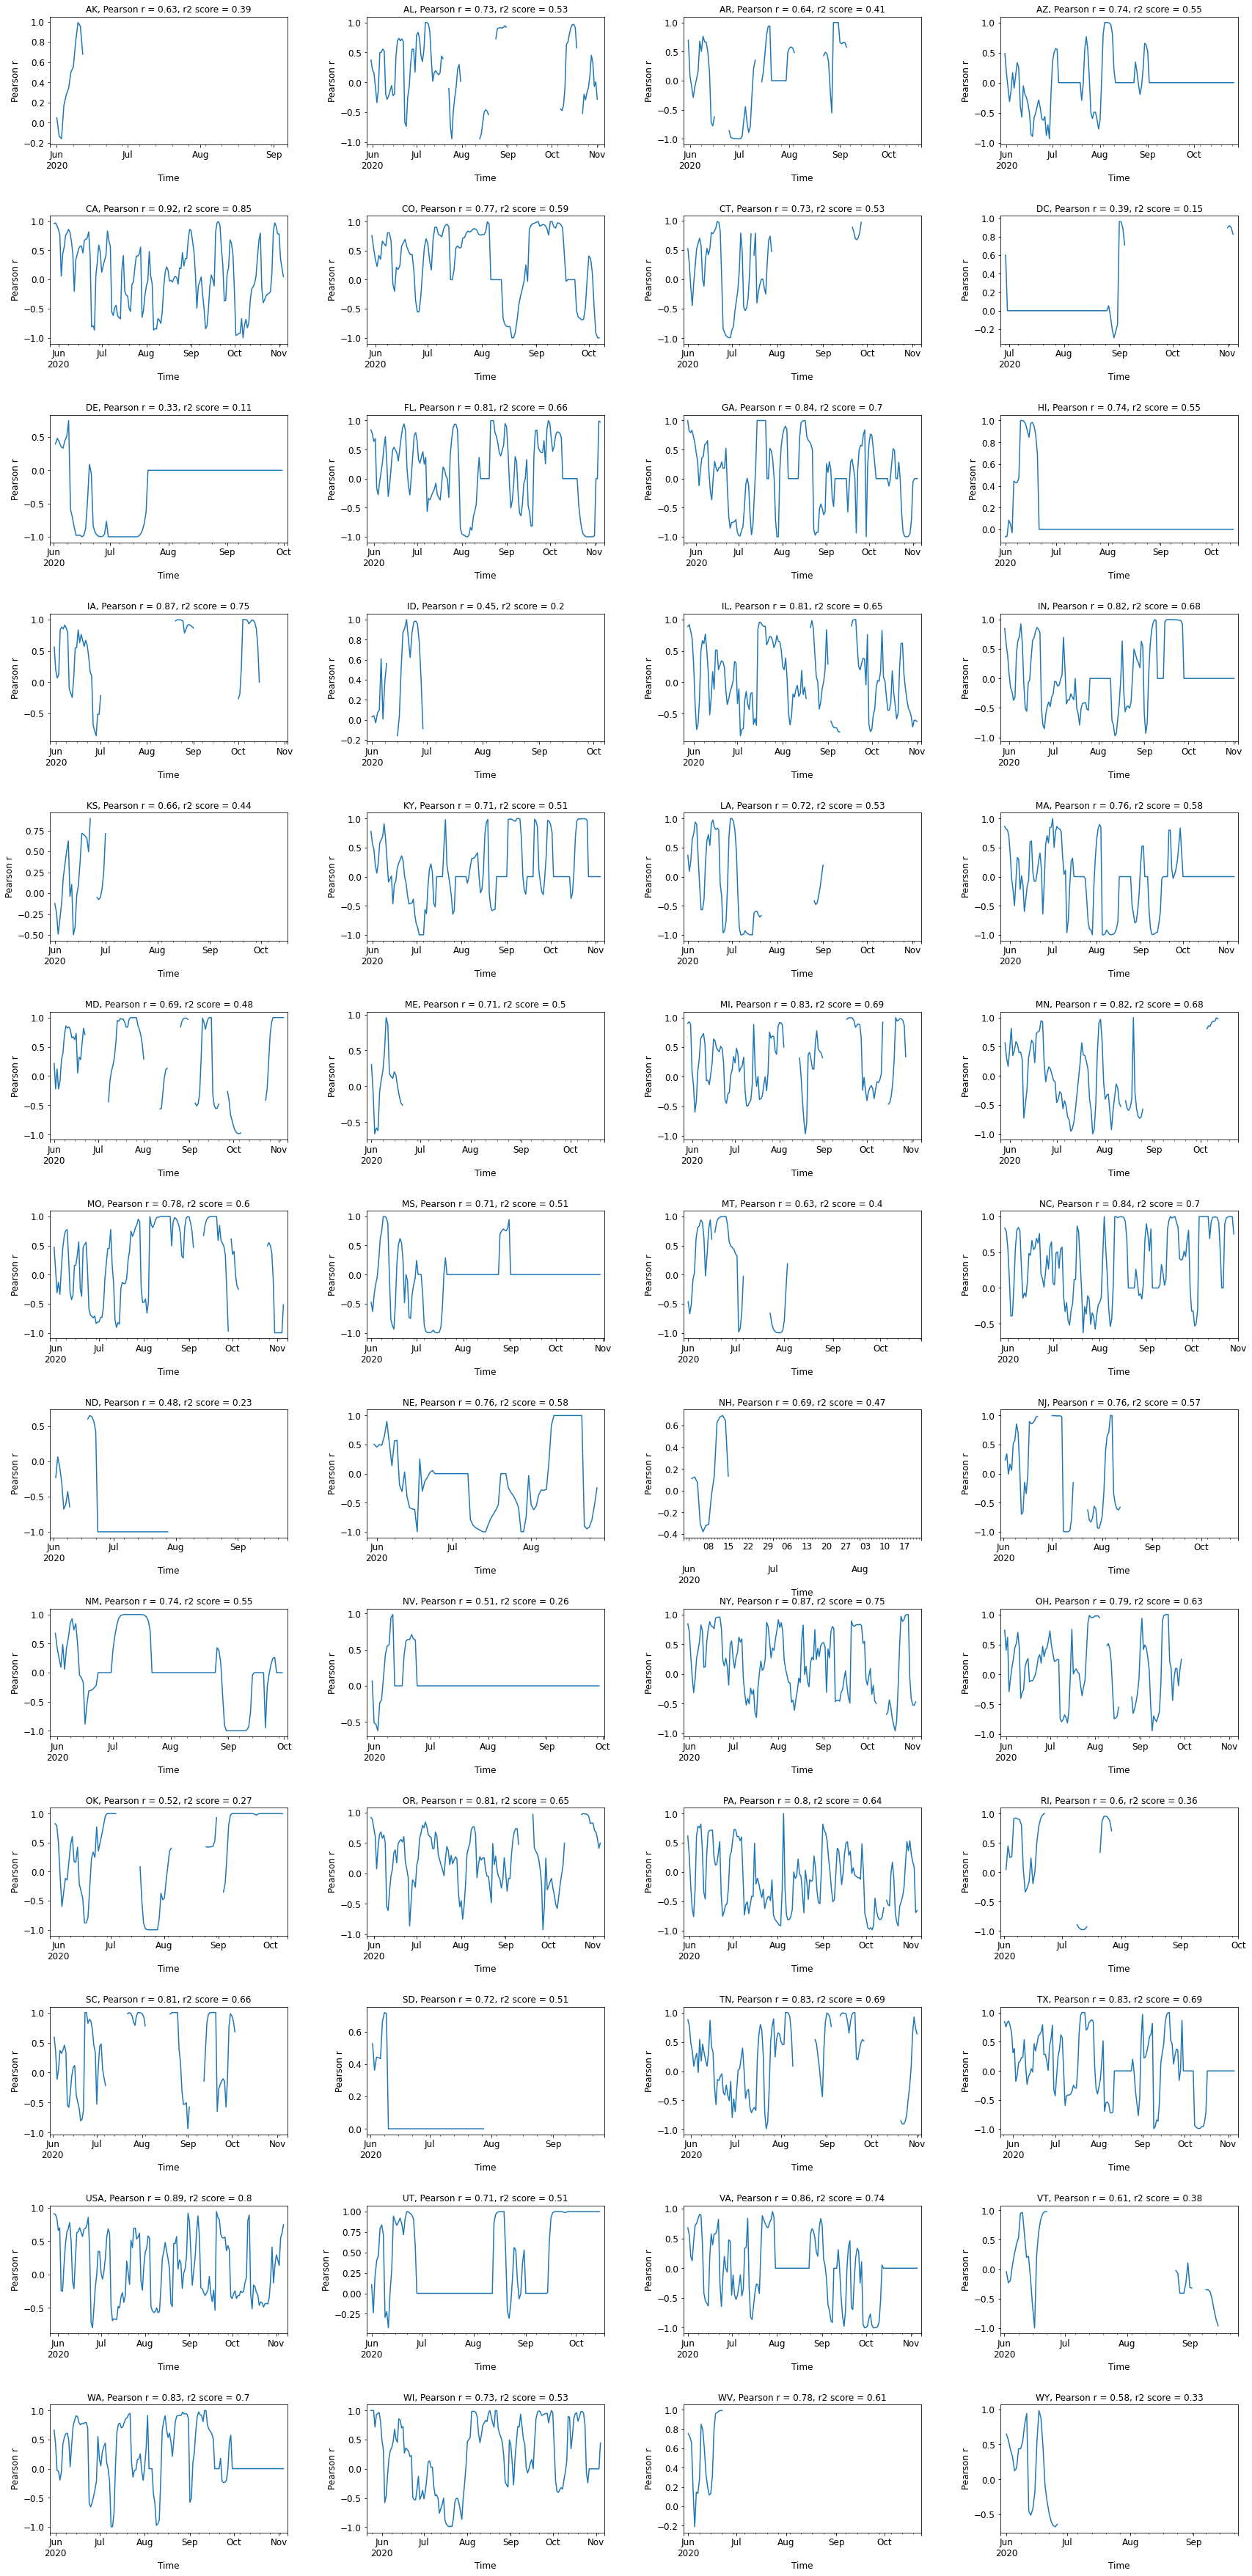

In [55]:
t_p = []
p_p = []
t_stat = []
p_stat = []
states = []
t_result = []
p_result = []

p_value = []
pearson_r = []
r2 = []

scaler = MinMaxScaler()

fig, axes = plt.subplots(13, 4, figsize=(25,50))
# fig.suptitle('3 rows x 4 columns axes with no data')
ax_num = 0
r_window_size = 7

fig.tight_layout(pad=6.0)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

axes = axes.flatten()

for state in df_rs['state'].unique():
    
    data = df_rs[df_rs['state']==state]
    states.append(state)
    # check distributions
    stat, p = stats.normaltest(data['tweet_count'])
    t_p.append(p)
    t_stat.append(stat)

    alpha = 0.05
    if p > alpha:
        t_result.append('Tweet data looks Gaussian (fail to reject null hypothesis)')
    else:
        t_result.append('Tweet data looks non-Gaussian (reject null hypothesis)')

    stat, p = stats.normaltest(data['protest_count'])
    p_p.append(p)
    p_stat.append(stat)
    
    alpha = 0.05
    if p> alpha:
        p_result.append('Protest data looks Gaussian (fail to reject null hypothesis)')
    else:
        p_result.append('Protest data looks non-Gaussian (reject null hypothesis)')
        
    data['tweet_count'] = scaler.fit_transform(data[['tweet_count']])
    data['protest_count'] = scaler.fit_transform(data[['protest_count']])

    # plot data

    r, p = stats.pearsonr(data.dropna()['tweet_count'], data.dropna()['protest_count'])
    
    p_value.append(p)
    pearson_r.append(r)
    r2.append(r**2)
    
    # Compute rolling window moving window synchrony.
#     f,ax=plt.subplots(figsize=(7,3))
#     df_rs.rolling(window=1,center=True).median().plot(ax=axes[ax_num])
#     ax.set(xlabel='Time',ylabel='Pearson r')
#     ax.set(title=f"Pearson r = {np.round(r,2)}, r2 score = {np.round(r**2,2)}");

    # Interpolate missing data.
    df_interpolated = data.interpolate()
    # Compute rolling window synchrony
    rolling_r = df_interpolated['tweet_count'].rolling(window=r_window_size, center=True).corr(df_interpolated['protest_count'])
#     f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
#     data.rolling(window=1,center=True).median().plot(ax=ax[ax_num])
#     ax[0].set(xlabel='Time',ylabel='Tweets/protests')
    rolling_r.plot(ax=axes[ax_num])
    axes[ax_num].set(xlabel='Time',ylabel='Pearson r', title=f"{state}, Pearson r = {np.round(r,2)}, r2 score = {np.round(r**2,2)}")
    
#     plt.suptitle(f"Smiling data and rolling window correlation for {state}, overall metrics: Pearson r = {np.round(r,2)}, r2 score = {np.round(r**2,2)}")
    

    ax_num +=1
    
stat_dict = {"state": states, "tweet_pvalue": t_p, "protest_pvalue": p_p, "tweet_statistic": t_stat, 
             "protest_statistic": p_stat, "tweet_normresult": t_result, "protest_normresult": p_result, 
             "corr_p_value": p_value, "pearson_r": pearson_r, "r2": r2}

stat_df = pd.DataFrame.from_dict(stat_dict)

plt.savefig("../reports/figures/rollw_corr_state.png", dpi=300)
#         facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

In [49]:
stat_df.to_csv("../data/raw/processed/stat_tests/state_normtest_corr_results.csv")

In [619]:
stat_df = pd.read_csv("../data/raw/processed/stat_tests/state_normtest_corr_results.csv")

In [620]:
print("Across 51 states, the median Pearson correlation value is", stat_df.pearson_r.median(), "and there are", len(stat_df[stat_df['pearson_r']>0.6]), "states associated with Pearson correlation values greater than 0.6.")
print("Across 51 states, the median R2 value is", stat_df.r2.median(), "and there are", len(stat_df[stat_df['r2']>0.5]), "states associated with Pearson correlation values greater than 0.5.")

Across 51 states, the median Pearson correlation value is 0.743590856269531 and there are 44 states associated with Pearson correlation values greater than 0.6.
Across 51 states, the median R2 value is 0.5529280948675509 and there are 37 states associated with Pearson correlation values greater than 0.5.


In [386]:
import geopandas as gpd
state_pop = pd.read_csv("../data/raw/us_admin/nst-est2019-alldata.csv")

In [387]:
state_geo = gpd.read_file("../data/raw/us_admin/cb_2018_us_state_500k.shp")

In [64]:
# state_geo

In [621]:
states_pop = pd.merge(state_geo, state_pop, on="NAME")[["STUSPS", "ALAND", 'POPESTIMATE2019']].rename({"STUSPS": "state"}, axis=1)
stat_df = pd.merge(states_pop, stat_df)
stat_df['pop_den'] = stat_df['POPESTIMATE2019']/stat_df['ALAND']*1000000

In [622]:
print("Across the 20 densest states, the median Pearson correlation value is", stat_df.sort_values("pop_den", ascending=False).head(20).pearson_r.median(), "and there are", len(stat_df.sort_values("pop_den", ascending=False).head(20)[stat_df.sort_values("pop_den", ascending=False).head(20)['pearson_r']>0.6]), "states associated with Pearson correlation values greater than 0.7.")
print("Across the 20 densest states, the median R2 value is", stat_df.sort_values("pop_den", ascending=False).head(20).r2.median(), "and there are", len(stat_df.sort_values("pop_den", ascending=False).head(20)[stat_df.sort_values("pop_den", ascending=False).head(20)['r2']>0.5]), "states associated with Pearson correlation values greater than 0.5.")

Across the 20 densest states, the median Pearson correlation value is 0.8010829702098441 and there are 17 states associated with Pearson correlation values greater than 0.7.
Across the 20 densest states, the median R2 value is 0.6417496396980216 and there are 16 states associated with Pearson correlation values greater than 0.5.


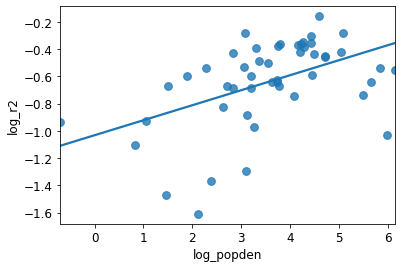

In [623]:
stat_df['log_r2'] = np.log(stat_df['r2'])
stat_df['log_popden'] = np.log(stat_df['pop_den'])
sns.regplot(data = stat_df[~stat_df['state'].isin(["USA", "DC", "DE"])], y = "log_r2", x = "log_popden", scatter_kws={"s": 60}, ci=False)

In [688]:
stat_df.sort_values("pop_den", ascending=False, inplace=True)
stat_df['pop_class'] = ""
stat_df.iloc[:12,-1] = "Top 25% Population Dense"
stat_df.sort_values("pop_den", ascending=True, inplace=True)
stat_df.iloc[:12,-1] = "Bottom 25% Population Dense"
# stat_df.sort_values("pop_den", ascending=False).tail(10)['pop_class'] = "Least Population Dense"

[Text(0, 0.5, ''), Text(0.5, 0, 'Model Accuracy')]

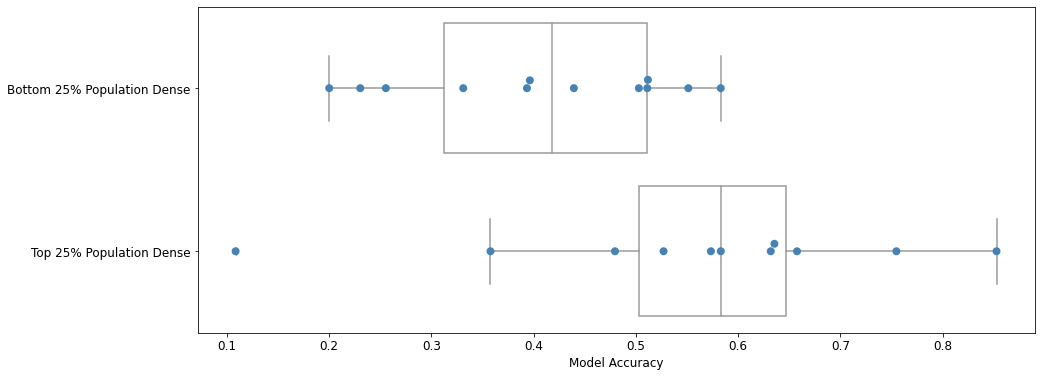

In [689]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(data = stat_df[(stat_df['pop_class']!="")&(~stat_df['state'].isin(["DC"]))], y="pop_class", x="r2", orient="h", color="white")
ax = sns.swarmplot(data = stat_df[(stat_df['pop_class']!="")&(~stat_df['state'].isin(["DC"]))], y="pop_class", x="r2", orient="h", color="steelblue", size=8)
ax.set(xlabel="Model Accuracy", ylabel="")

In [700]:
# stat_df.sort_values("r2", ascending=True).head(20)

In [8]:
# stat_df.sort_values("pop_den", ascending=False).head(20)

#### Check data distributions

In [58]:
stat,p = stats.normaltest(df['tweet_count'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Tweet data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Tweet data looks non-Gaussian (reject null hypothesis)')
# output: Statistics = 658.293, p=0.000 Data looks Gaussian (reject null hypothesis

Statistics = 135.797, p=0.000
Tweet data looks non-Gaussian (reject null hypothesis)


In [59]:
from scipy import stats
stat,p = stats.normaltest(df['protest_count'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Protest data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Protest data looks non-Gaussian (reject null hypothesis)')
# output: Statistics = 658.293, p=0.000 Data looks Gaussian (reject null hypothesis

Statistics = 154.165, p=0.000
Protest data looks non-Gaussian (reject null hypothesis)


#### 1. Pearson Correlation

In [146]:
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time_lag.csv")
df_p_t_state = pd.read_csv("../data/raw/processed/state_tp_time.csv")
df = df_p_t[['date','tweet_count', 'protest_count']]
df_state = df_p_t_state[['date','tweet_count', 'protest_count', "state"]]
df['state'] = 'USA'
df = pd.concat([df_state, df])
df.date = pd.to_datetime(df.date)

df.index = df.date
df = df.drop("date", axis=1)

scaler = MinMaxScaler()
# normalized

for area in df['state'].unique():
    df['tweet_count'][df['state']==area] = list(scaler.fit_transform(df[df['state']==area][['tweet_count']]).flatten())
    df['protest_count'][df['state']==area] = list(scaler.fit_transform(df[df['state']==area][['protest_count']]).flatten())


# INTERPOLATE MISSING VALUES
df_rs = df.groupby('state').resample('D').mean().reset_index().set_index("date")
df_rs['tweet_count'], df_rs['protest_count'] = df_rs['tweet_count'].interpolate(), df_rs['protest_count'].interpolate()

Pandas computed Pearson r: 0.8687261118207185
Scipy computed Pearson r: 0.8687261118207177 and p-value: 2.65715612279906e-51


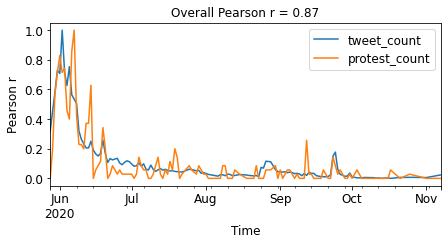

In [152]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

area = "NY"

overall_pearson_r = df_rs[df_rs['state']==area].corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df_rs[df_rs['state']==area].dropna()['tweet_count'], df_rs[df_rs['state']==area].dropna()['protest_count'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df_rs[df_rs['state']==area].rolling(window=1,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

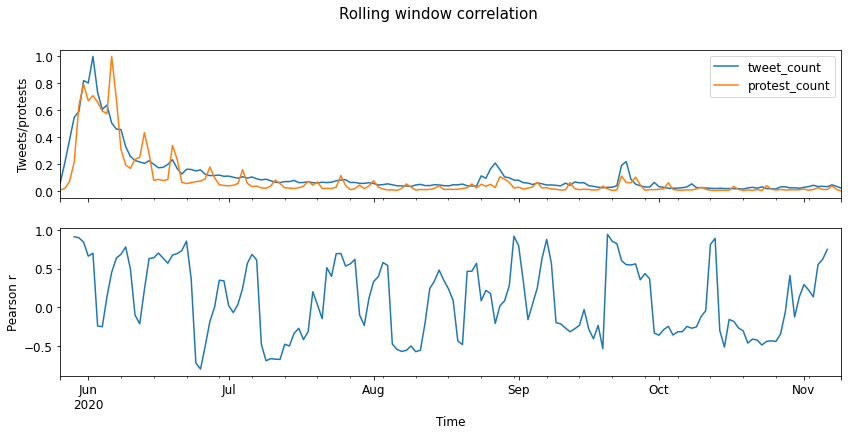

In [384]:
# Set window size to compute moving window synchrony.
r_window_size = 7
# Interpolate missing data.
df_interpolated = df_rs[df_rs['state']=="USA"].interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['tweet_count'].rolling(window=r_window_size, center=True).corr(df_interpolated['protest_count'].rolling(window=r_window_size, center=True))
# rolling_r = df_interpolated[['tweet_count', "protest_count"]].rolling(r_window_size).corr(pairwise=True)
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df_rs[df_rs['state']=="USA"].rolling(window=1,center=True).mean().plot(ax=ax[0])
ax[0].set(xlabel='Time',ylabel='Tweets/protests')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Time',ylabel='Pearson r')
plt.suptitle("Rolling window correlation")
plt.savefig("../reports/figures/2_rollingWindowTot.PNG", dpi=300)

In [380]:
# rolling_r

In [381]:
# roll = df_interpolated[['tweet_count', "protest_count"]].rolling(r_window_size).corr(pairwise=True).reset_index()
# roll.index = pd.to_datetime(roll.date)
# rolling_r = roll[roll['level_1']=="protest_count"][['tweet_count']]

#### 2. Time Lagged Cross Correlation

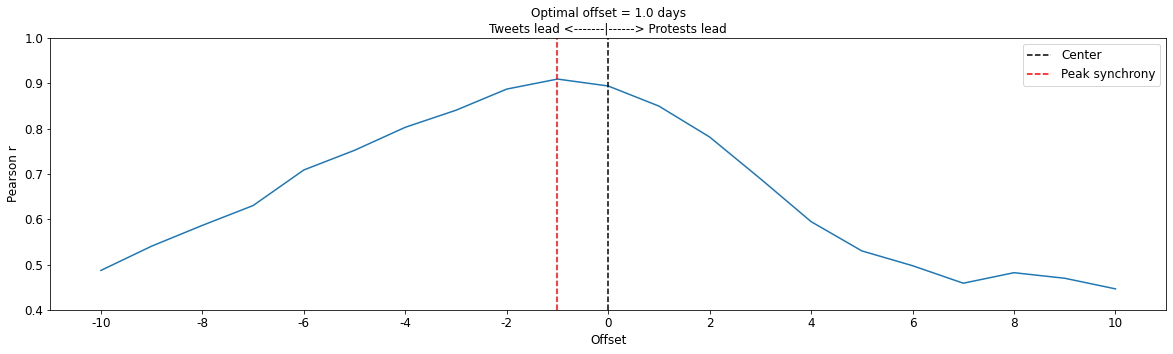

In [325]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    


d1 = df_rs[df_rs['state']=="USA"]['tweet_count']
d2 = df_rs[df_rs['state']=="USA"]['protest_count']
days = 10
rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(20,5))
ax.plot(rs)
ax.axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead',ylim=[0.4,1], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10,]);
plt.legend()
plt.savefig("../reports/figures/6_timeLaggedCrossTot.PNG", dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

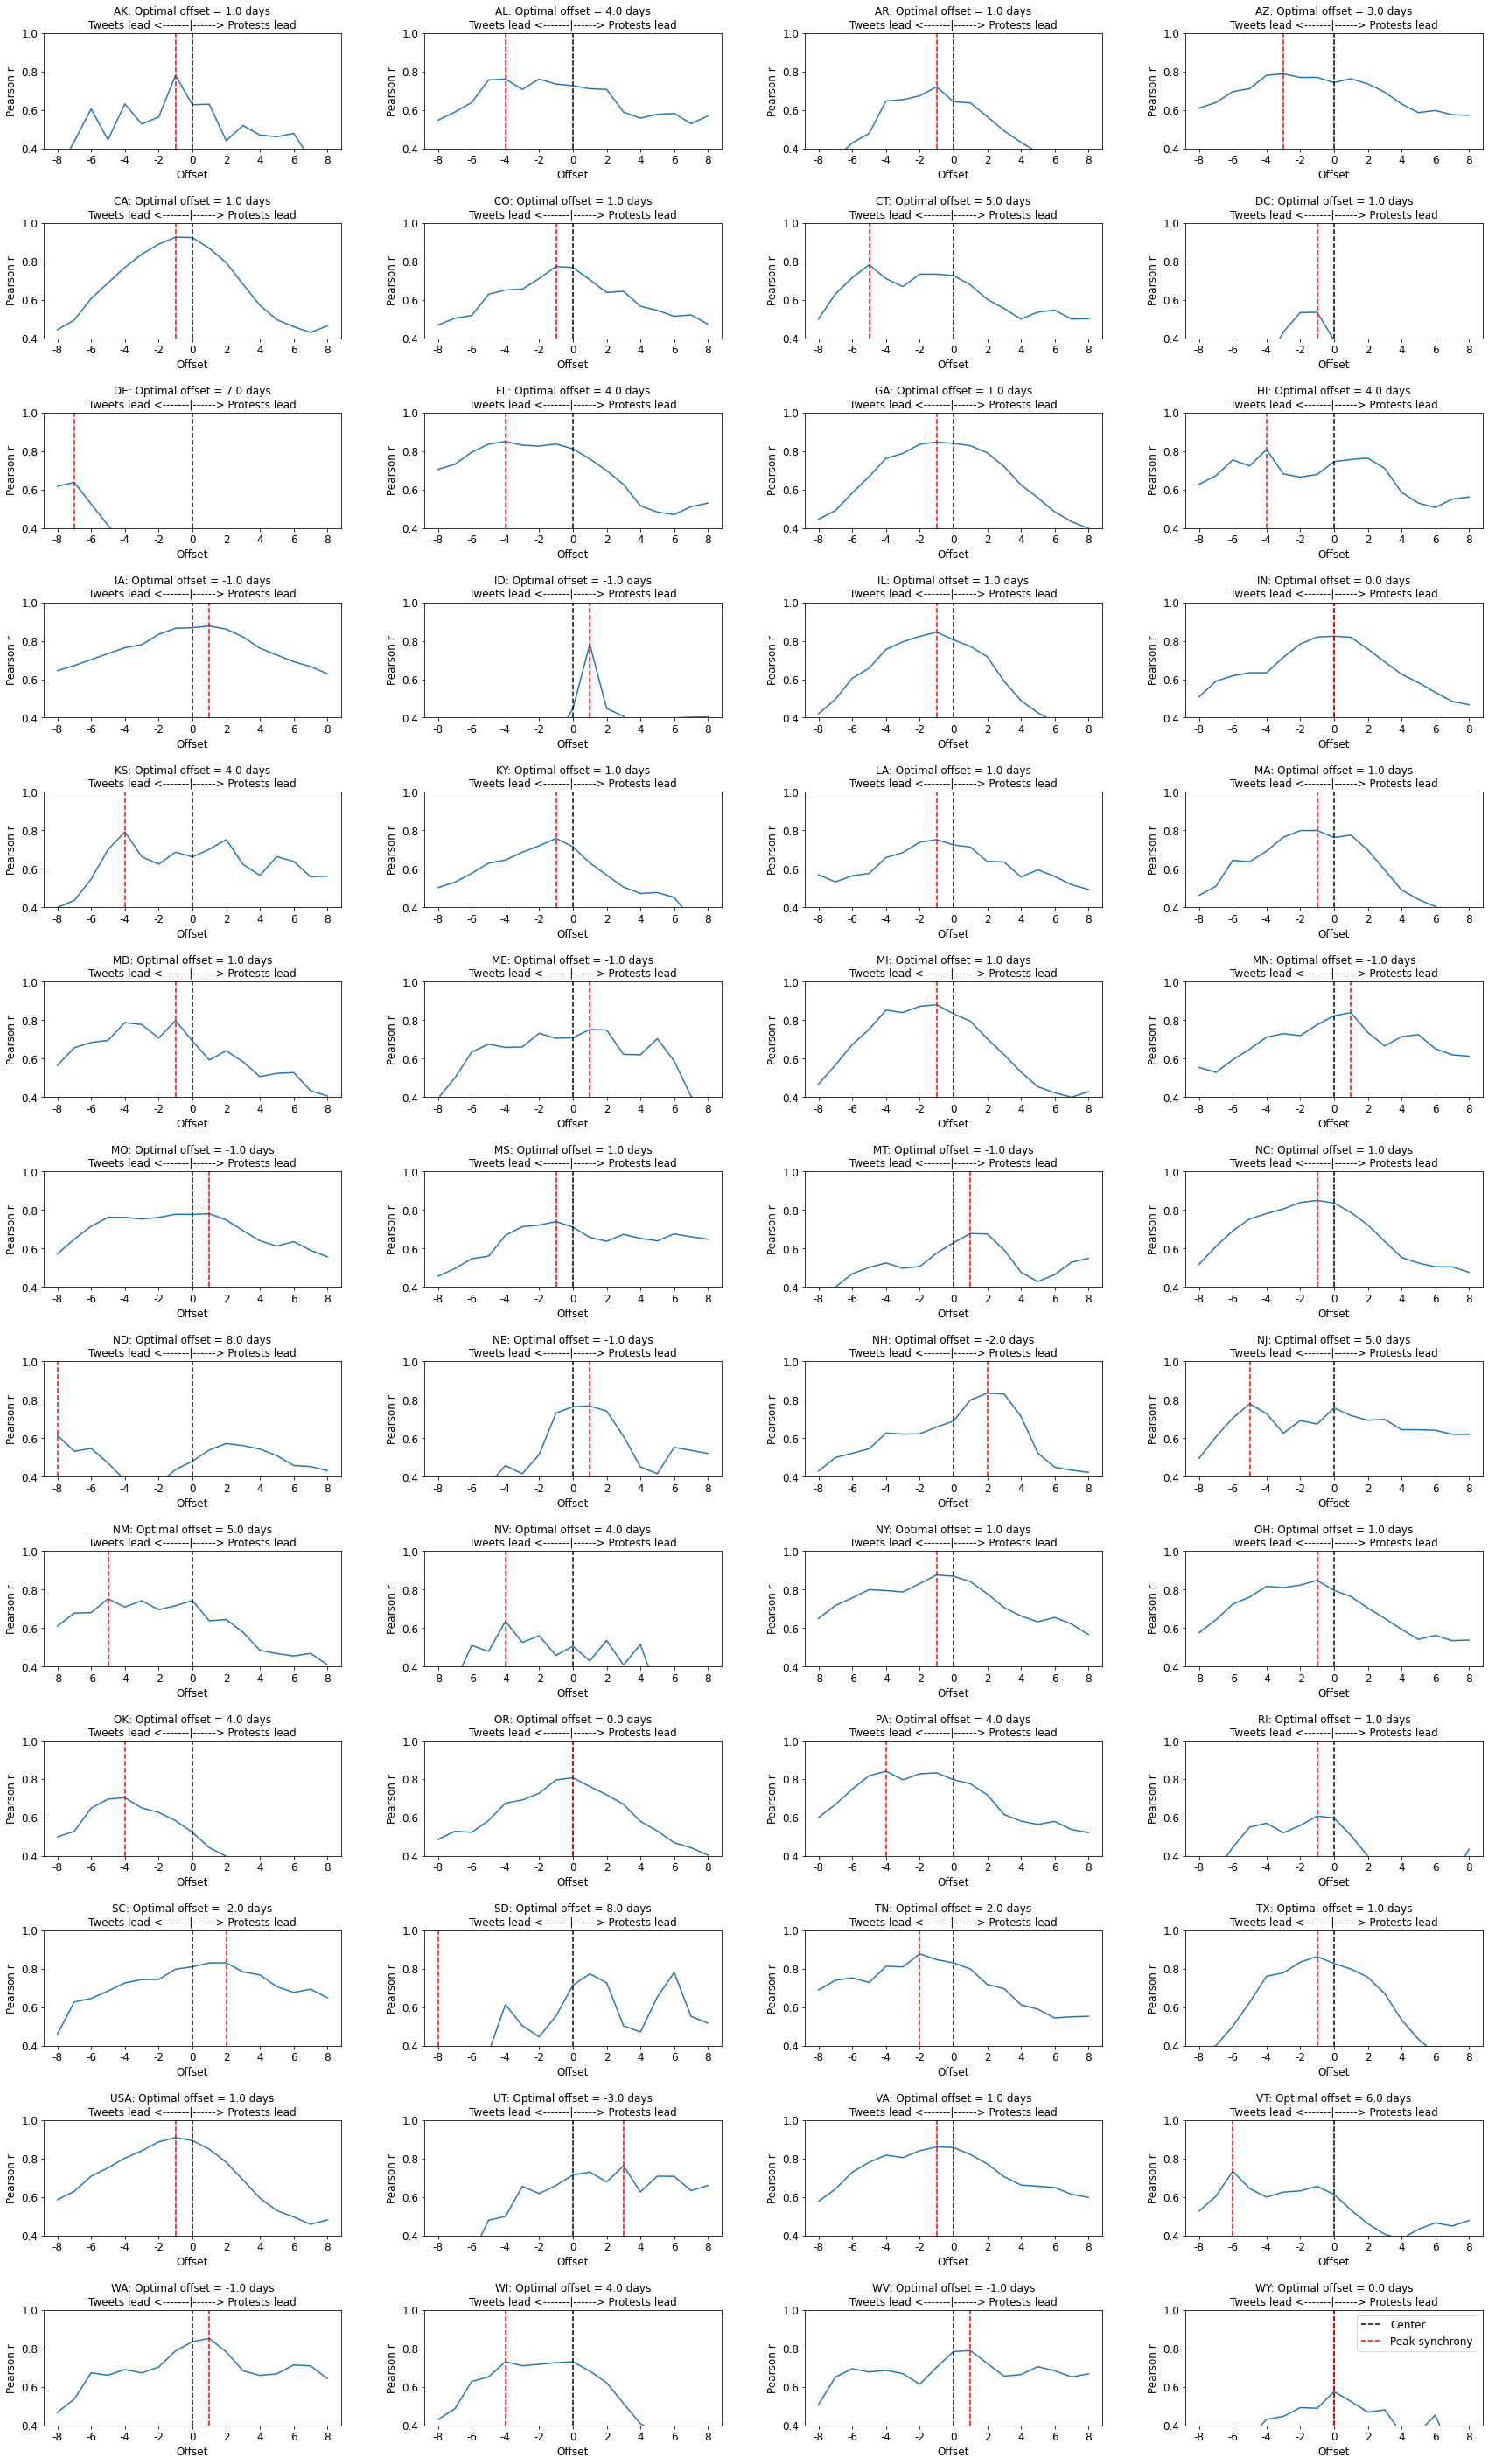

In [158]:
fig, axes = plt.subplots(13, 4, figsize=(25,40))
# fig.suptitle('3 rows x 4 columns axes with no data')
fig.tight_layout(pad=5.0)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax_num = 0

axes = axes.flatten()

for state in df_rs['state'].unique():
    
    data = df_rs[df_rs['state']==state]
    d1 = data['tweet_count']
    d2 = data['protest_count']
    days = 8
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)
#     f,ax=plt.subplots(figsize=(14,3))
    axes[ax_num].plot(rs)
    axes[ax_num].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
    axes[ax_num].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    axes[ax_num].set(title=f'{state}: Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead',ylim=[0.4,1], xlabel='Offset',ylabel='Pearson r')
    axes[ax_num].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
    axes[ax_num].set_xticklabels([-8, -6, -4, -2, 0, 2, 4, 6, 8]);
    plt.legend()
    
    ax_num +=1
    
plt.savefig("../reports/figures/tlcross_corr_state.png", dpi=300)

#### Notes
- In 41 out of 51 states a better correlation is obtained when tweets lead by 1 or more days
- In all states, the highest correlations are obtained when levels of tweeting and protesting are above average (peak anomalies), but on "regular" days we obtain lower correlations. 

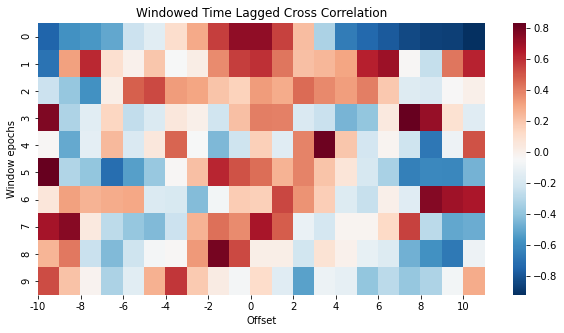

In [64]:
# Windowed time lagged cross correlation
days = 10
no_splits = 10
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['tweet_count'][int((t)*samples_per_split):int((t+1)*samples_per_split)]
    d2 = df['protest_count'][int((t)*samples_per_split):int((t+1)*samples_per_split)]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation', xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10,]);

# # Rolling window time lagged cross correlation
# days = 10
# window_size = 10 #samples
# t_start = 0
# t_end = t_start + window_size
# step_size = 30
# rss=[]
# while t_end < 5400:
#     d1 = df['S1_Joy'].iloc[t_start:t_end]
#     d2 = df['S2_Joy'].iloc[t_start:t_end]
#     rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(days),int(days+1))]
#     rss.append(rs)
#     t_start = t_start + step_size
#     t_end = t_end + step_size
# rss = pd.DataFrame(rss)

# f,ax = plt.subplots(figsize=(10,10))
# sns.heatmap(rss,cmap='RdBu_r',ax=ax)
# ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,301], xlabel='Offset',ylabel='Epochs')
# ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
# ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

#### 3. Dynamic Time Warping — synchrony of signals varying in lengths

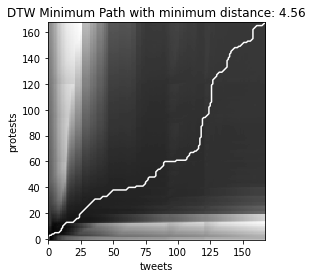

In [65]:
from dtw import dtw,accelerated_dtw

d1 = df['tweet_count'].interpolate().values
d2 = df['protest_count'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('tweets')
plt.ylabel('protests')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

### Granger Causality Analysis and Co-integration test
 
 Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (x) do not cause the other series (y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

In [161]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=7

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(df_rs[df_rs['state']=="USA"][["tweet_count", "protest_count"]], variables = df_rs.columns[1:])  

tweet_count_x  protest_count_x
tweet_count_y              1.0           0.0001
protest_count_y            0.0           1.0000

In [166]:
maxlag=1

test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df[df['state']=="USA"][["protest_count", "tweet_count"]], variables = ["protest_count", "tweet_count"]) 

protest_count_x  tweet_count_x
protest_count_y           1.0000            0.0
tweet_count_y             0.6817            1.0

In [63]:
# grangercausalitytests(df[df['state']=="USA"][["protest_count", "tweet_count"]], maxlag=4, verbose=True, addconst=True)

In [171]:
dfs = []
for state in df_rs['state'].unique():
    data = df_rs[df_rs['state']==state]
    g_df = grangers_causality_matrix(data[["protest_count", "tweet_count"]], variables = data.columns[1:])  
    g_df['state'] = state
    dfs.append(g_df)

granger_results = pd.concat(dfs)

In [177]:
granger_results.to_csv("../data/raw/processed/stat_tests/state_granger_results.csv")

In [173]:
# granger_results.head(50)

In [174]:
granger_results = granger_results.reset_index()
granger_stat = granger_results[granger_results['index']=="protest_count_y"][['index','tweet_count_x', 'state']]

In [175]:
granger_stat.columns = ['granger_relationship', 'p_value', 'state']
granger_stat['granger_relationship'] = "tweet_count -> protest_count"

In [73]:
# granger_stat

In [178]:
print("For", len(granger_stat[granger_stat['p_value']<0.05]), "out of 51 States, tweet count granger causes protest count")

For 49 out of 51 States, tweet count granger causes protest count


In [179]:
granger_stat.to_csv("../data/raw/processed/stat_tests/state_granger.csv")

In [180]:
print("For", len(granger_results[(granger_results['index']=="protest_count_y")&(granger_results['tweet_count_x']<0.05)]), "states we can reject the null-hypothesis that tweet count does not cause protest count")

For 49 states we can reject the null-hypothesis that tweet count does not cause protest count


In [181]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

var = []
test_stat = []
c95 = []
signif = []

def cointegration_test(df_data, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df_data,0,1)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_data.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        var.append(adjust(col))
        test_stat.append(adjust(round(trace,2), 9))
        c95.append(adjust(cvt, 8))
        signif.append(trace > cvt)
        
    coint_df = pd.DataFrame.from_dict({"variable":var, "test_statistic":test_stat, "C(95%)":c95, "signif":signif})  
    return coint_df



coint_df = cointegration_test(df_rs[df_rs['state']=="USA"][["tweet_count", "protest_count"]])
coint_df

variable test_statistic    C(95%)  signif
0    tweet_count      102.67     15.4943     True
1  protest_count      6.01       3.8415      True

In [96]:
# coint_johansen(df[df['state']=="OK"][["tweet_count", "protest_count"]],0,1).lr1

In [182]:
var = []
test_stat = []
c95 = []
signif = []
state = []
dfs = []

for state in df_rs['state'].unique():
    data = df_rs[df_rs['state']==state]
#     state.append(state)
#     coint = np.NaN
    coint_result = cointegration_test(data[["tweet_count", "protest_count"]])
    coint_result['state'] = state
#     print(coint.iloc[-2:, :])
    dfs.append(coint_result.iloc[-2:, :])
    
coint_df = pd.concat(dfs)

In [184]:
coint_df.to_csv("../data/raw/processed/stat_tests/cointegration_results.csv")

In [183]:
coint_df[coint_df['signif']==True]

variable test_statistic    C(95%)  signif state
0      tweet_count      36.47      15.4943     True    AK
1    protest_count      7.73       3.8415      True    AK
2      tweet_count      112.54     15.4943     True    AL
3    protest_count      8.15       3.8415      True    AL
4      tweet_count      32.98      15.4943     True    AR
..             ...            ...       ...     ...   ...
99   protest_count      5.43       3.8415      True    WI
100    tweet_count      155.93     15.4943     True    WV
101  protest_count      14.26      3.8415      True    WV
102    tweet_count      16.24      15.4943     True    WY
103  protest_count      5.82       3.8415      True    WY

[103 rows x 5 columns]

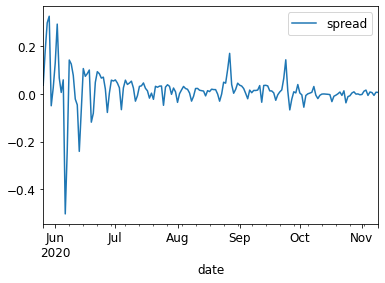

In [185]:
# spread
df_rs['spread'] = df_rs["tweet_count"] -df_rs["protest_count"]
df_rs[df_rs['state']=="USA"][["spread"]].plot()

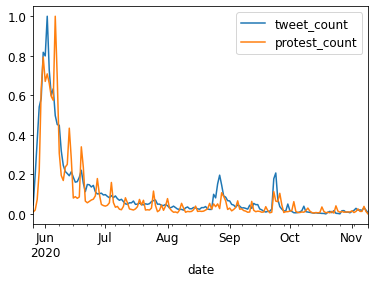

In [186]:
df_rs[df_rs['state']=="USA"][["tweet_count", "protest_count"]].plot()


### Vector Auto Regressive Model
- BEST RESULTS FOR USA: nobs = 30, lags = 10
- BEST RESULTS FOR DISAGG: nobs = 30, lags = 10

In [282]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#### Train model on full dataset and predict individual states

In [304]:
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time_lag.csv")
df_p_t_state = pd.read_csv("../data/raw/processed/state_tp_time.csv")
df = df_p_t[['date','tweet_count', 'protest_count']]
df_state = df_p_t_state[['date','tweet_count', 'protest_count', "state"]]
df['state'] = 'USA'
df = pd.concat([df_state, df])
df.date = pd.to_datetime(df.date)

df.index = df.date
df = df.drop("date", axis=1)

scaler = MinMaxScaler()

In [ ]:
# normalized
for area in df['state'].unique():
    df['tweet_count'][df['state']==area] = list(scaler.fit_transform(df[df['state']==area][['tweet_count']]).flatten())
    df['protest_count'][df['state']==area] = list(scaler.fit_transform(df[df['state']==area][['protest_count']]).flatten())

# df['tweet_count'] = list(scaler.fit_transform(df[['tweet_count']]).flatten())
# df['protest_count'] = list(scaler.fit_transform(df[['protest_count']]).flatten())
# INTERPOLATE MISSING VALUES
df_rs = df.groupby('state').resample('D').mean().reset_index().set_index("date")
df_rs['tweet_count'], df_rs['protest_count'] = df_rs['tweet_count'].interpolate(), df_rs['protest_count'].interpolate()

In [305]:
# ALTERNATIVE WAY
area = "USA"
# data = df[df['state']==area][["tweet_count", "protest_count"]]
# data = df[["tweet_count", "protest_count"]]
df['tweet_count'] = list(scaler.fit_transform(df[['tweet_count']]).flatten())
df['protest_count'] = list(scaler.fit_transform(df[['protest_count']]).flatten())

data = df.rename_axis('date').sort_values(['state', "date"])#[["tweet_count", "protest_count"]]

In [116]:
# n_obs=40
# X_train, X_test = df[df['state']=="USA"][0:-n_obs], df[df['state']=="USA"][-n_obs:]
# print(X_train.shape, X_test.shape)

In [306]:
# INTERPOLATE MISSING VALUES
df_rs = data.groupby('state').resample('D').mean().reset_index().set_index("date")
df_rs['tweet_count'], df_rs['protest_count'] = df_rs['tweet_count'].interpolate(), df_rs['protest_count'].interpolate()

In [560]:
# len(df_rs[df_rs['state']=="NY"])#.plot()

In [566]:
# states = []
# days = []
# for area in df_rs['state'].unique():
#     states.append(area)
#     days.append(len(df_rs[df_rs['state']==area]))

In [527]:
# plt.plot(days)

In [ ]:
# # nobs = 30
# nobs = 30
# df_train, df_test = df_rs[0:-nobs], df_rs[-nobs:]

# # Check size
# print(df_train.shape)  # (119, 8)
# print(df_test.shape)  # (4, 8)

In [307]:
# nobs = 30
# ADD MISSING DAYS
nobs = 20
dfs_train = []
dfs_test = []
for area in df_rs['state'].unique():
    
    data_train = df_rs[df_rs['state']==area][0:-nobs]#[["tweet_count", "protest_count"]]
    data_test = df_rs[df_rs['state']==area][-nobs:]#[["tweet_count", "protest_count"]]
    dfs_train.append(data_train)
    dfs_test.append(data_test)
    
df_train, df_test = pd.concat(dfs_train), pd.concat(dfs_test)

# Check size
print(df_rs.shape)
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(7735, 3)
(6695, 3)
(1040, 3)


In [568]:
# df_test.plot()

In [308]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

        
# ADF Test on each column
# for name, column in df_train.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')
for name, column in df_train.drop('state', axis=1).iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "tweet_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.1416
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "protest_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8472
 No. Lags Chosen       = 35
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [309]:
model = VAR(df_train.drop('state', axis=1))
# for i in [1,2,3,4,5,6,7,8,9]:
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

In [228]:
x = model.select_order(maxlags=20)
# x.summary()

In [316]:
lags = 20
model_fitted = model.fit(maxlags=lags, ic='aic') #(lags)
# model_fitted.summary()

In [299]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_rs.drop('state', axis=1).columns, out):
    print(col, ':', round(val, 2))

tweet_count : 2.01
protest_count : 1.99


In [317]:
# for area in df_rs['state'].unique():
area = "USA"

# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train[df_train['state']==area].drop('state', axis=1).values[-lag_order:]
# forecast_input

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_results = pd.DataFrame(fc, index=df_rs[df_rs['state']==area].index[-nobs:], columns=df_rs.drop('state', axis=1).columns + '_forecast')
# df_forecast

20


In [682]:
# #ONLY IF DATA HAS BEEN DIFFERENTIATED BEFORE (BECAUSE NON STATIONARY)
# def invert_transformation(df_train, df_forecast, second_diff=False):
#     """Revert back the differencing to get the forecast to original scale."""
#     df_fc = df_forecast.copy()
#     columns = df_train.columns
#     for col in columns:        
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_forecast'].cumsum()
#         # Roll back 1st Diff
#         df_fc[str(col)+'_forecast_diff'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
#     return df_fc

# df_results = invert_transformation(df_train[df_train['state']==area].drop('state', axis=1), df_forecast, second_diff=True)        
# # df_results

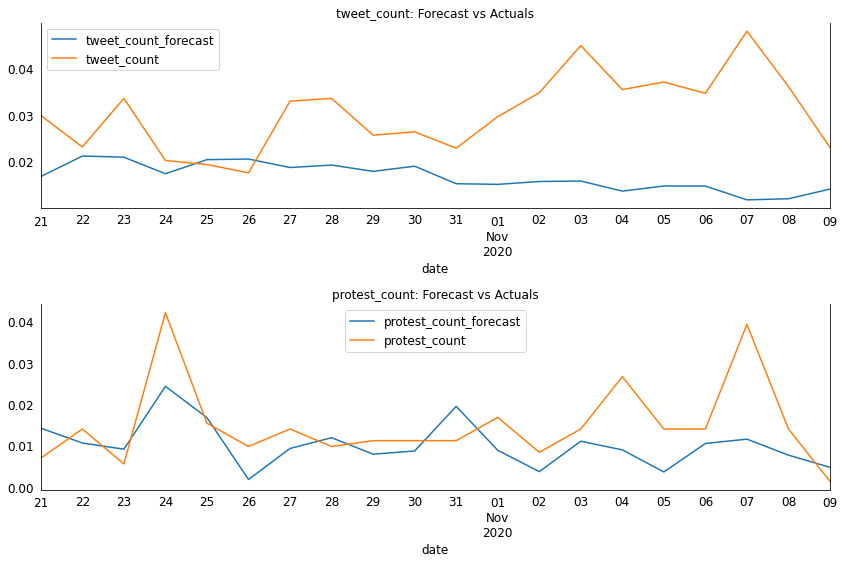

In [333]:
fig, axes = plt.subplots(nrows=2, ncols=1,  figsize=(12,8)) #dpi=150,
for i, (col,ax) in enumerate(zip(df_rs.drop('state', axis=1).columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[df_test['state']==area].drop('state', axis=1)[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    #     ax.tick_params(labelsize=6)

plt.tight_layout();

In [319]:
col = "protest_count"

fig, axes = plt.subplots(nrows=13, ncols=4,  figsize=(25,50)) #dpi=150,
# for i, (col,ax) in enumerate(zip(df_rs.drop('state', axis=1).columns, axes.flatten())):
ax_num = 0
axes = axes.flatten()

model = VAR(df_train.drop('state', axis=1))

for area in df_rs[~df_rs['state'].isin(["AK", "HI", "ME", "NH", "SD", "WY"])]['state'].unique():
    
    model_fitted = model.fit(maxlags=lags, ic='aic') #(lags)
    # Get the lag order
    lag_order = model_fitted.k_ar
    # Input data for forecasting
    forecast_input = df_train[df_train['state']==area].drop('state', axis=1).values[-lag_order:]
    # forecast_input
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_results = pd.DataFrame(fc, index=df_rs[df_rs['state']==area].index[-nobs:], columns=df_rs.drop('state', axis=1).columns + '_forecast')
    
    df_results[col+'_forecast'].plot(legend=True, ax=axes[ax_num]).autoscale(axis='x',tight=True)
    df_test[df_test['state']==area].drop('state', axis=1)[col][-nobs:].plot(legend=True, ax=axes[ax_num]);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    axes[ax_num].set(xlabel='',ylabel='Protest Count', title=f"{area}")
    
    ax_num += 1
    
plt.tight_layout();

In [669]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: tweet_count')
accuracy_prod = forecast_accuracy(df_results['tweet_count_forecast'].values,  df_test[df_test['state']==area]['tweet_count'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: protest_count')
accuracy_prod = forecast_accuracy(df_results['protest_count_forecast'].values,  df_test[df_test['state']==area]['protest_count'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: tweet_count
mape :  0.5405
me :  -0.0148
mae :  0.0159
mpe :  -0.5023
rmse :  0.0187
corr :  0.4089
minmax :  0.5352

Forecast Accuracy of: protest_count
mape :  1.7281
me :  -0.011
mae :  0.0154
mpe :  -0.3176
rmse :  0.0172
corr :  0.2823
minmax :  1.1317


In [671]:
model_fitted.plot_acorr()

#### Train individual model on subset state datasets and predict individual states

ERROR! Session/line number was not unique in database. History logging moved to new session 2113


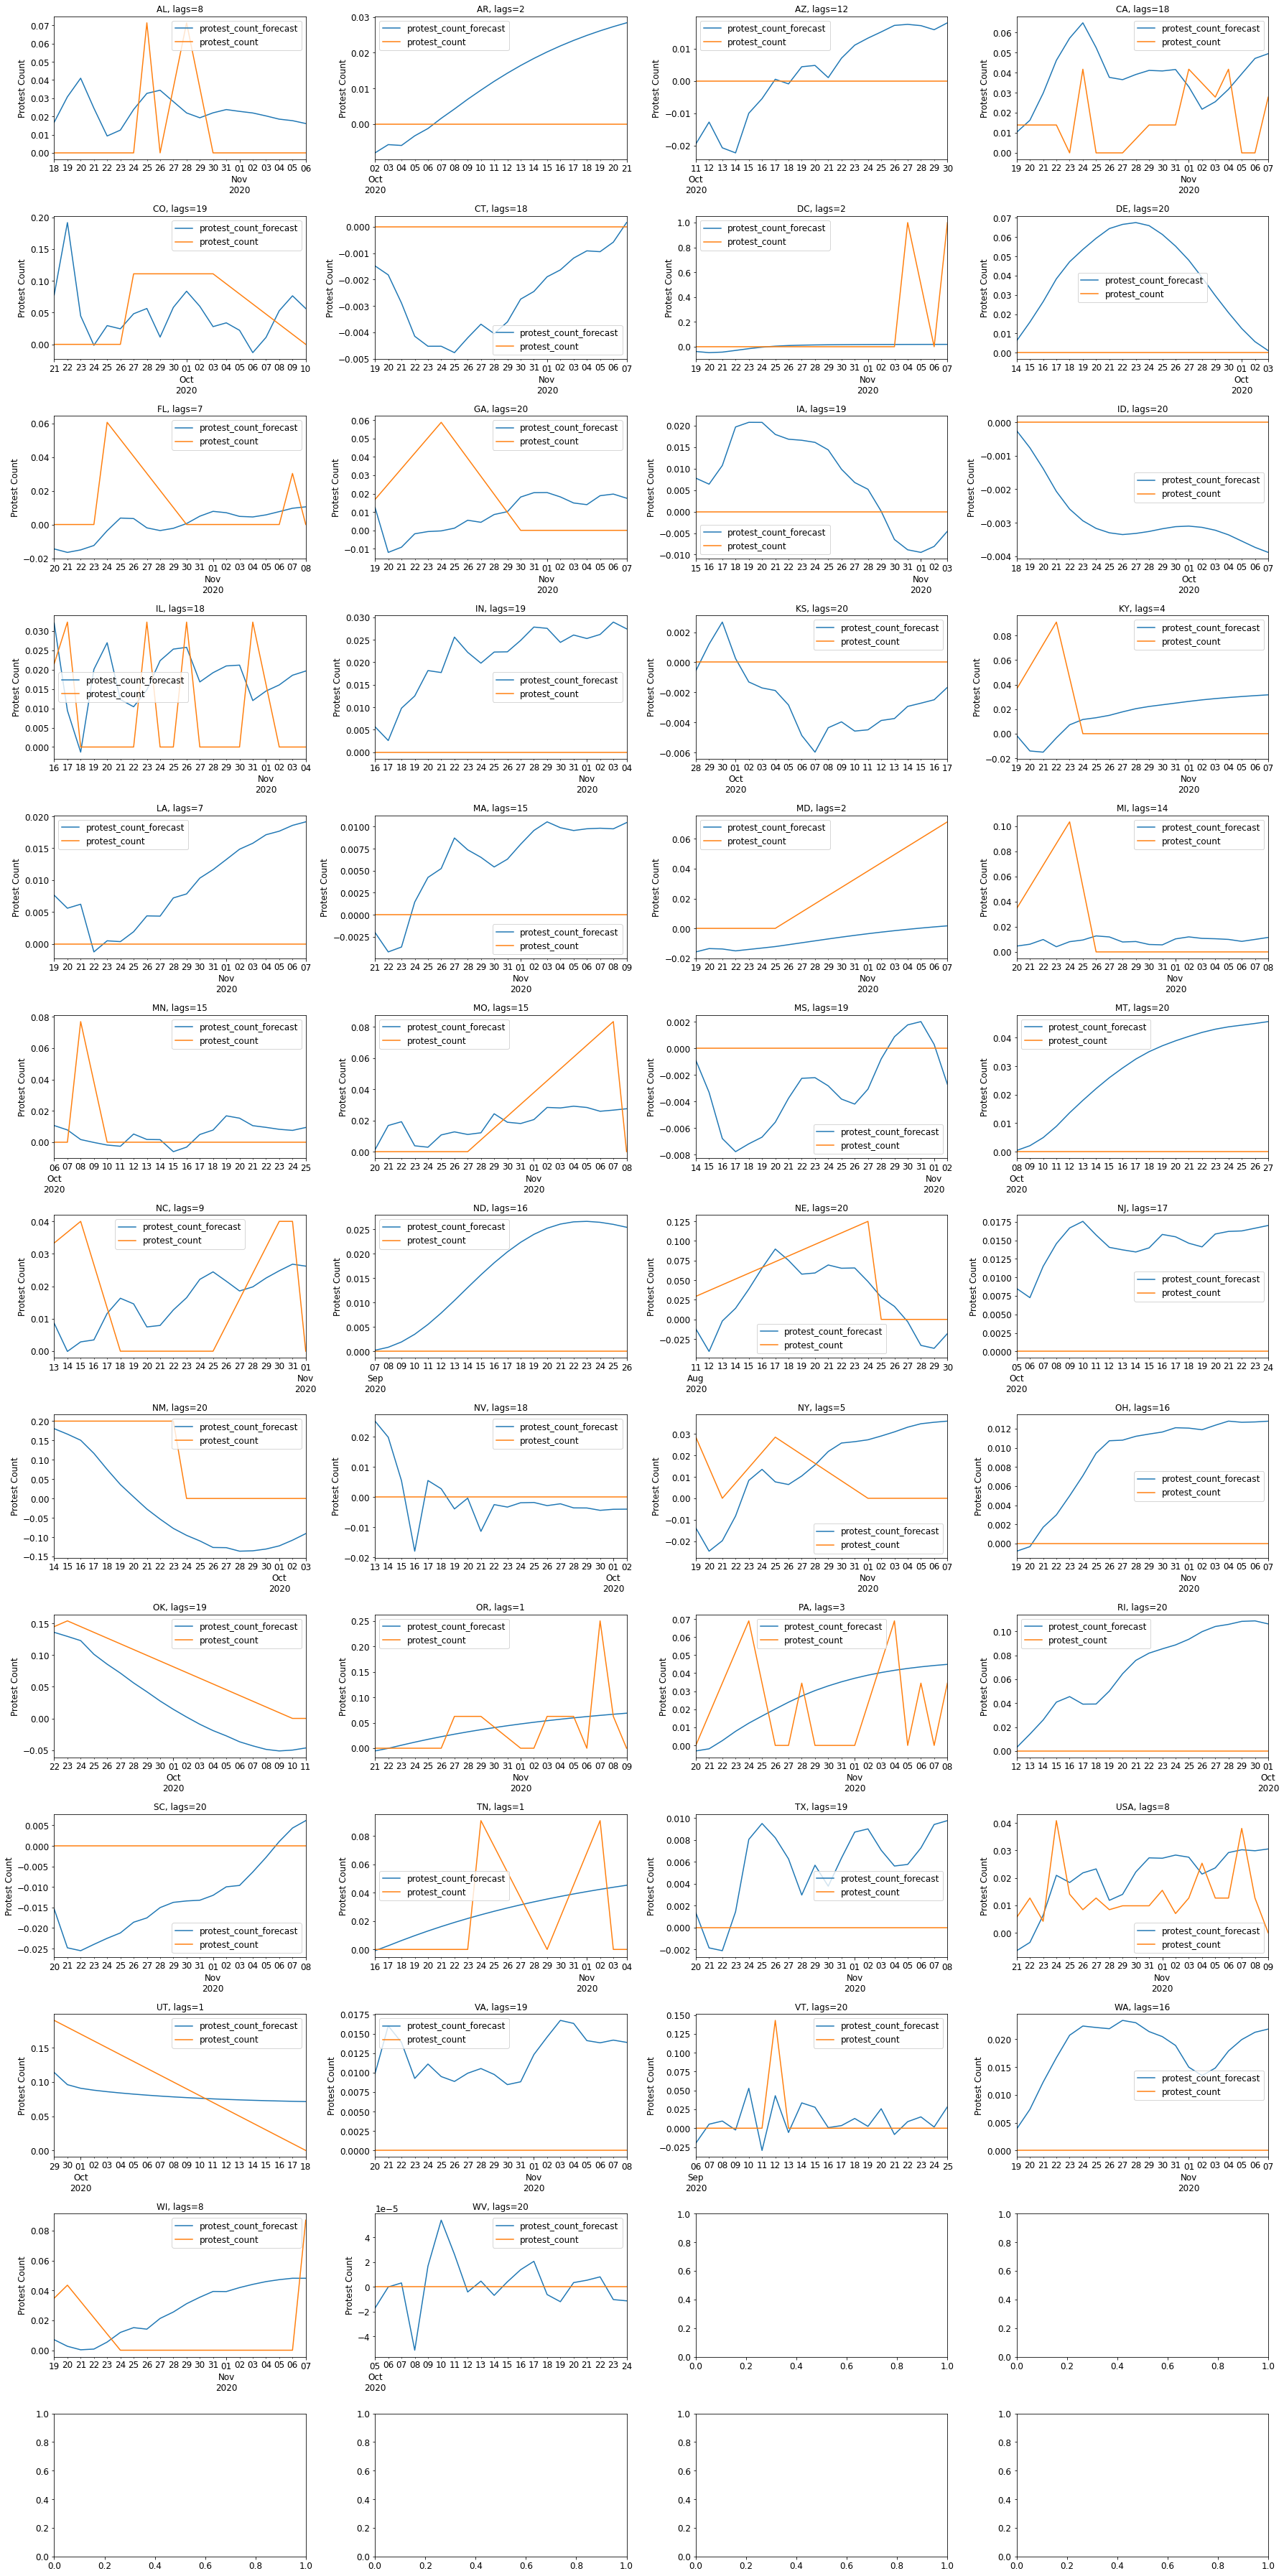

In [281]:
col = "protest_count"

fig, axes = plt.subplots(nrows=12, ncols=4,  figsize=(25,50)) #dpi=150,
# for i, (col,ax) in enumerate(zip(df_rs.drop('state', axis=1).columns, axes.flatten())):
ax_num = 0
axes = axes.flatten()
lags = 20

for area in df_rs[~df_rs['state'].isin(["AK", "HI", "ME", "NH", "SD", "WY"])]['state'].unique():
    
    model = VAR(df_train[df_train['state']==area].drop('state', axis=1))
    
    model_fitted = model.fit(maxlags=lags, ic='aic') #(lags)
    # Get the lag order
    lag_order = model_fitted.k_ar
    # Input data for forecasting
    forecast_input = df_train[df_train['state']==area].drop('state', axis=1).values[-lag_order:]
    # forecast_input
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_results = pd.DataFrame(fc, index=df_rs[df_rs['state']==area].index[-nobs:], columns=df_rs.drop('state', axis=1).columns + '_forecast')
    
    df_results[col+'_forecast'].plot(legend=True, ax=axes[ax_num]).autoscale(axis='x',tight=True)
    df_test[df_test['state']==area].drop('state', axis=1)[col][-nobs:].plot(legend=True, ax=axes[ax_num]);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    axes[ax_num].set(xlabel='',ylabel='Protest Count', title=f"{area}, lags={lag_order}")
    
    ax_num += 1
    
plt.tight_layout();

In [258]:
# model = VAR(df_train[df_train['state']=="AK"].drop('state', axis=1))
    
# model_fitted = model.fit(maxlags=lags, ic='aic') #(lags)

# lag_order = model_fitted.k_ar
# lag_order

### VAR + LSTM

In [448]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasRandomSearch, KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [449]:
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time_lag.csv")
df_p_t_state = pd.read_csv("../data/raw/processed/state_tp_time.csv")
df = df_p_t[['date','tweet_count', 'protest_count']]
df_state = df_p_t_state[['date','tweet_count', 'protest_count', "state"]]
df['state'] = 'USA'
df = pd.concat([df_state, df])
df.date = pd.to_datetime(df.date)

df.index = df.date
df = df.drop("date", axis=1)

scaler = MinMaxScaler()

In [560]:
# normalized
# for area in df['state'].unique():
#     df['tweet_count'][df['state']==area] = list(scaler.fit_transform(df[df['state']==area][['tweet_count']]).flatten())
#     df['protest_count'][df['state']==area] = list(scaler.fit_transform(df[df['state']==area][['protest_count']]).flatten())

# df['tweet_count'] = list(scaler.fit_transform(df[['tweet_count']]).flatten())
# df['protest_count'] = list(scaler.fit_transform(df[['protest_count']]).flatten())
# INTERPOLATE MISSING VALUES
# df_rs = df.groupby('state').resample('D').mean().reset_index().set_index("date")
df_rs = df.groupby('state').resample('h').mean().reset_index().set_index("date")#UPSAMPLE DATA TO HOUR
df_rs['tweet_count'], df_rs['protest_count'] = df_rs['tweet_count'].interpolate(), df_rs['protest_count'].interpolate()

In [971]:
### SPLIT TRAIN TEST ###
area = "USA"
data = df_rs[df_rs['state']==area][["tweet_count","protest_count"]]

train, test = train_test_split(data, shuffle=False, train_size=0.6)

print(train.shape, test.shape)

(2405, 2) (1604, 2)


In [564]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

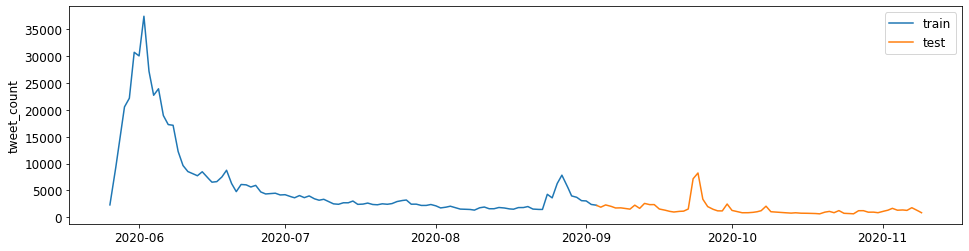

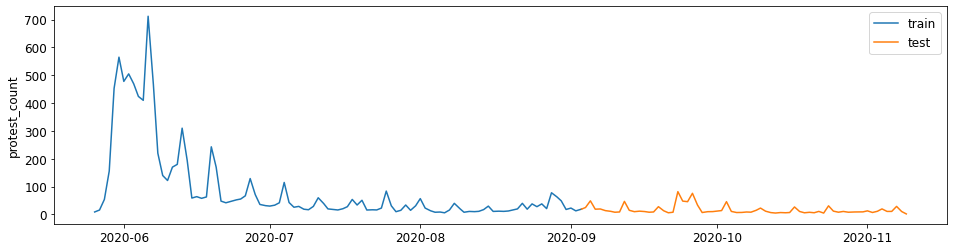

In [565]:
### PLOT ORIGINAL SERIES ###
for col in data.columns:
    plot_sensor(col)

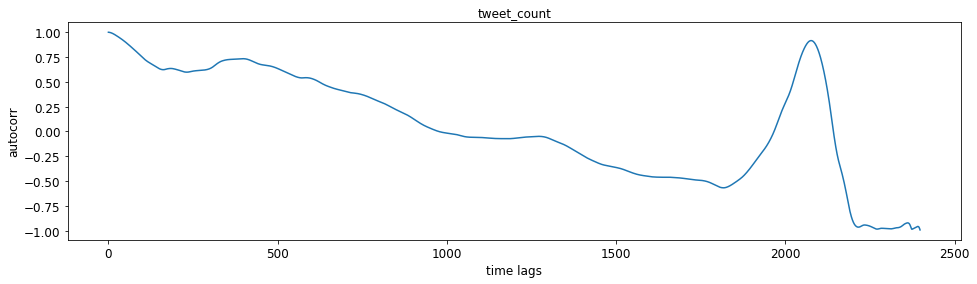

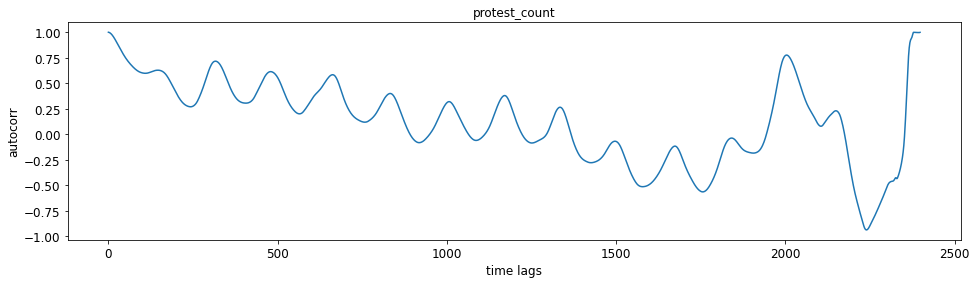

In [566]:
### PLOT AUTOCORRELATION ###
for col in data.columns:
    plot_autocor(col, train)

In [489]:
### FIND BEST VAR ORDER ###
AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(1,300)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:44<00:00,  6.70it/s]

BEST ORDER: 290 BEST AIC: 0.9008245409233206


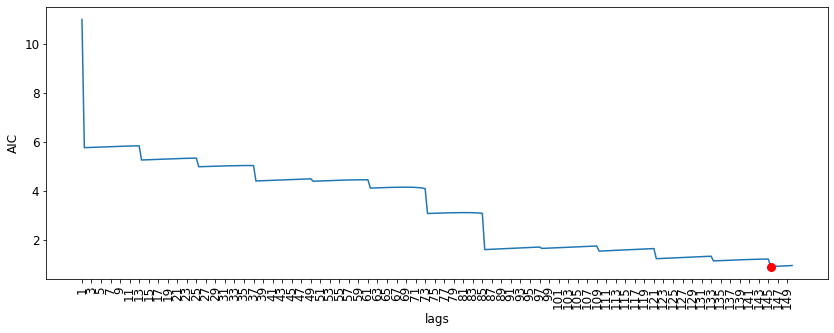

In [567]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 4), range(1,300, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [568]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

0.9008245409233206

In [544]:
# lag_order = var_result.k_ar

# # Input data for forecasting
# forecast_input = train.values[-lag_order:]
# # forecast_input

# fc = var_result.forecast(y=forecast_input, steps=1000)
# # df_results = pd.DataFrame(fc, index=train.index[-nobs:], columns=train.columns + '_forecast')
# df_results = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_forecast')

In [543]:
# fig, axes = plt.subplots(nrows=2, ncols=1,  figsize=(12,8)) #dpi=150,
# for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
#     df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
#     test[col][-nobs:].plot(legend=True, ax=ax);
#     ax.set_title(col + ": Forecast vs Actuals")
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     #     ax.tick_params(labelsize=6)

# plt.tight_layout();

In [579]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):
    
    set_seed(33)
    
    opt = Adam()
    opt.lr = param['lr']
        
    inp = Input(shape=(look_back, 2))
    
    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='tanh', 
             return_sequences=True)(x)
    out = TimeDistributed(Dense(2))(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model


def get_model_finetune(param, kgs, look_ahead, look_back):
    
    set_seed(33)
    
    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())
    
    best_model_config.optimizer.lr = param['lr']
    
    return best_model_config

In [580]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [128, 96, 64], 
    'lr': [7e-4, 1e-3, 3e-3], 
    'epochs': 200, 
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025), 
    'epochs': 200, 
}

In [569]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = var_result.fittedvalues

X_train = train.iloc[best_order:].values 
# np.concatenate([
#     train.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)

X_train_var = var_result.fittedvalues

# np.concatenate([
#     var_result.fittedvalues, train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=False, train_size=0.8)

X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(
    X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = test.values
# np.concatenate([test.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(1692, 2) (423, 2) (1604, 2)
(1692, 2) (423, 2)
(1692, 2) (423, 2) (1604, 2)
(1692, 2) (423, 2)


In [570]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [574]:
### BUILD DATA GENERATOR ###
look_back = 24*2
look_ahead = 6

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)

X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(1639, 48, 2) (370, 48, 2) (1551, 48, 2)
(1639, 48, 2) (370, 48, 2)
(1639, 6, 2) (370, 6, 2) (1551, 6, 2)
(1639, 6, 2) (370, 6, 2)


In [581]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###
es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs_var = KerasGridSearch(hypermodel, param_grid, 
                          monitor='val_loss', greater_is_better=False, tuner_verbose=1)

kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.01696 at epoch 44

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.02066 at epoch 61

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.00908 at epoch 27

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.01098 at epoch 40

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.01505 at epoch 37

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.01645 at epoch 61

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.01899 at epoch 54

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 20

<kerashypetune.KerasGridSearch>

In [582]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)  

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'], 
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 0.0055 at epoch 34

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 0.00489 at epoch 35

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 0.00926 at epoch 11

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 0.00695 at epoch 27

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 0.00629 at epoch 40

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 0.00929 at epoch 11

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 0.00479 at epoch 40

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 0.00979 at epoch 11

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 0.00967 at epoch 11

***** (10/20) *****
Search({'lr': 9.772977050450925e-05, '

<kerashypetune.KerasRandomSearch>

In [583]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)

In [584]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs = KerasGridSearch(hypermodel, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.01696 at epoch 44

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.02066 at epoch 61

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.00908 at epoch 27

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.01098 at epoch 40

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.01505 at epoch 37

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.01645 at epoch 61

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.01899 at epoch 54

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 20

<kerashypetune.KerasGridSearch>

In [585]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)

In [972]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(data.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = np.sqrt(error)
    
#     error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
#     error_baseline[col] = np.sqrt(error)

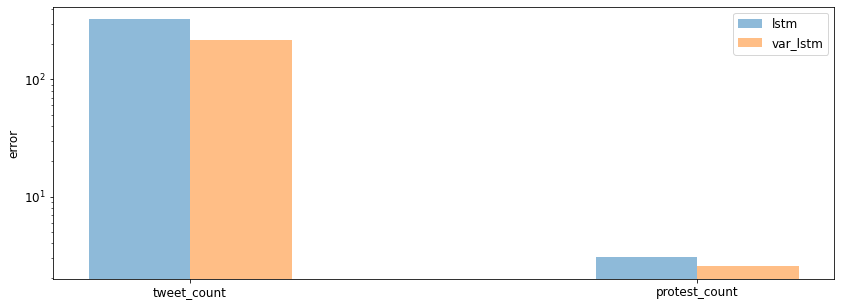

In [977]:
### COMPARE RESULTS ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(error_lstm))-0.1, error_lstm.values(), 
        alpha=0.5, width=0.2, label='lstm')
plt.bar(np.arange(len(error_var_lstm))+0.1, error_var_lstm.values(), 
        alpha=0.5, width=0.2, label='var_lstm')
# plt.bar(np.arange(len(error_baseline))+0.3, error_baseline.values(), 
#         alpha=0.5, width=0.2, label='baseline')
plt.xticks(range(len(error_lstm)), error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)
plt.yscale("log")

In [763]:
krs_ft.best_model.summary()

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 48, 2)]           0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 128)               67072     
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 6, 128)            0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 6, 128)            131584    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 6, 2)              258       
Total params: 198,914
Trainable params: 198,914
Non-trainable params: 0
_________________________________________________________________


In [918]:
error_baseline

{'tweet_count': 162.58123063804052, 'protest_count': 2.6771712204727636}

In [778]:
# kgs.best_model.save("../models/lstm")
# krs_ft.best_model.save("../models/lstm_var")
kgs.best_model.save_weights("../models/lstm_w")
krs_ft.best_model.save_weights("../models/lstm_var_w")

In [978]:
# len(pred_lstm_var[...,1])

In [979]:
# len(X_test[...,1])

In [858]:
# prepare test data in original format
look_back_window = int(look_back/2)
# X_test_orig = scaler_y.inverse_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [1069]:
df_predictions = test.iloc[look_back_window*2:1551+look_back_window*2,:].copy()
df_predictions['tweet_count_pred_lstm'] = [d[int(len(d)/2)] for d in pred_lstm[...,0]]
df_predictions['protest_count_pred_lstm'] = [d[int(len(d)/2)] for d in pred_lstm[...,1]]
df_predictions['tweet_count_pred_lstm_var'] = [d[int(len(d)/2)] for d in pred_lstm_var[...,0]]
df_predictions['protest_count_pred_lstm_var'] = [d[int(len(d)/2)] for d in pred_lstm_var[...,1]]
# df_predictions['state'] = "USA"
df_predictions.to_csv("../data/raw/processed/stat_tests/lstm_predictions.csv")

In [1066]:
df_predictions.head()

tweet_count  protest_count  tweet_count_pred_lstm  \
date                                                                     
2020-09-05 05:00:00  2269.541667          42.75            2308.842773   
2020-09-05 06:00:00  2260.250000          41.50            2312.878906   
2020-09-05 07:00:00  2250.958333          40.25            2315.528320   
2020-09-05 08:00:00  2241.666667          39.00            2316.974121   
2020-09-05 09:00:00  2232.375000          37.75            2317.350342   

                     protest_count_pred_lstm  tweet_count_pred_lstm_var  \
date                                                                      
2020-09-05 05:00:00                46.664413                2280.861328   
2020-09-05 06:00:00                44.675755                2271.018066   
2020-09-05 07:00:00                42.523666                2260.082275   
2020-09-05 08:00:00                40.310467                2248.914307   
2020-09-05 09:00:00                38.115917                2238.081055   

                     protest_count_pred_lstm_var  
date                                              
2020-09-05 05:00:00                    45.120220  
2020-09-05 06:00:00                    43.032909  
2020-09-05 07:00:00                    40.841427  
2020-09-05 08:00:00                    38.653187  
2020-09-05 09:00:00                    36.546463

In [1067]:
df_predictions_long = df_predictions.reset_index().melt(id_vars=["date"], value_vars = df_predictions.columns).set_index("date")

[Text(0, 0.5, 'Protest Count')]

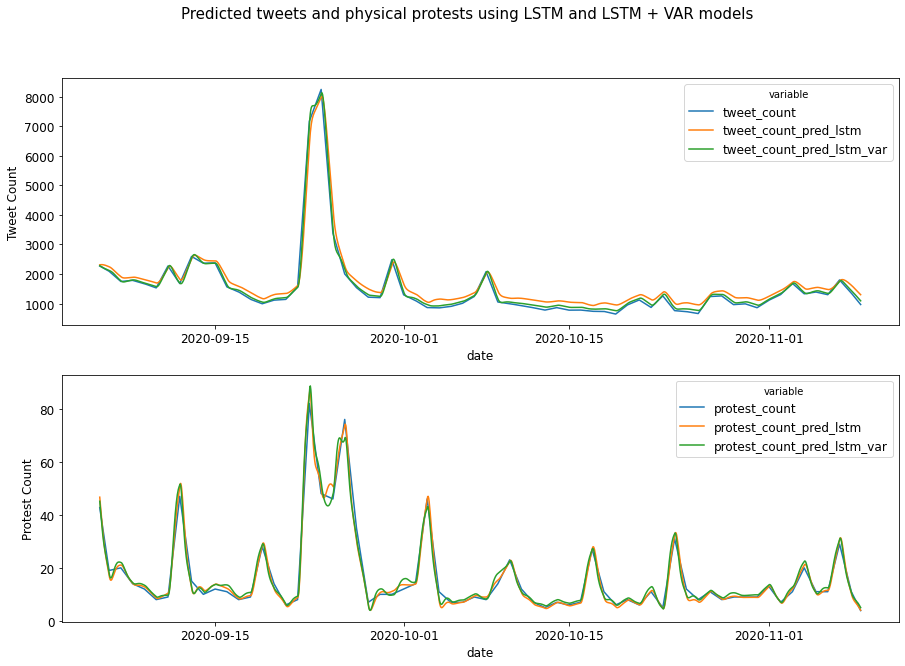

In [1068]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
ax = ax.flatten()
pred_tweets = df_predictions_long[df_predictions_long['variable'].str.contains("tweet")]
pred_prot = df_predictions_long[df_predictions_long['variable'].str.contains("protest")]
ax0 = sns.lineplot(data = pred_tweets, x = pred_tweets.index, y = "value", hue="variable", ax = ax[0])
ax1 = sns.lineplot(data = pred_prot, x = pred_prot.index, y = "value", hue="variable", ax = ax[1])

plt.suptitle("Predicted tweets and physical protests using LSTM and LSTM + VAR models")
ax0.set(ylabel = "Tweet Count")
ax1.set(ylabel = "Protest Count")

#### Test model to state data

In [994]:
%%time
# fig, axes = plt.subplots(nrows=12, ncols=4,  figsize=(25,50)) #dpi=150,
# ax_num = 0
# axes = axes.flatten()

pred_dfs = []

for area in df_rs[df_rs['state']!="USA"]['state'].unique():
    
    # subset data
    state_data = df_rs[df_rs['state']==area][["tweet_count","protest_count"]]
    state_train, state_test = train_test_split(state_data, shuffle=False, train_size=0.6)
    
    # get testing data
    y_train_state = state_train.iloc[best_order:].values
    X_train_state = state_train.iloc[best_order:].values 

    X_train_state, X_val_state, y_train_state, y_val_state = train_test_split(
        X_train_state, y_train_state, shuffle=False, train_size=0.8)
    
    # scale data
    scaler = StandardScaler()
    scaler_y = StandardScaler()

    y_train_state = scaler_y.fit_transform(y_train_state)

    X_test_state = state_test.values
    y_test_state = state_test.values
    
    X_test_state = scaler.fit_transform(X_test_state)
    X_test_state = create_windows(X_test_state, window_shape = look_back, end_id = -look_ahead)
    y_test_state = create_windows(y_test_state, window_shape = look_ahead, start_id = look_back)

    # predict on state data with national model
    pred_lstm_var_state = krs_ft.best_model.predict(X_test_state)
    pred_lstm_var_state = scaler_y.inverse_transform(pred_lstm_var_state.reshape(-1, pred_lstm_var_state.shape[-1])).reshape(pred_lstm_var_state.shape)
    pred_lstm_state = kgs.best_model.predict(X_test_state)
    pred_lstm_state = scaler_y.inverse_transform(pred_lstm_state.reshape(-1, pred_lstm_state.shape[-1])).reshape(pred_lstm_state.shape)

    ### COMPUTE METRICS ON TEST DATA ###
    # TO FINISH
    error_lstm_state, error_var_lstm_state = {}, {}
#     error_baseline_state = {}

    for i,col in enumerate(state_data.columns):

        error = mean_squared_error(y_test_state[...,i], pred_lstm_state[...,i])
        error_lstm_state[col] = np.sqrt(error)

        error = mean_squared_error(y_test_state[...,i], pred_lstm_var_state[...,i])
        error_var_lstm_state[col] = np.sqrt(error)

#         error = mean_squared_error(y_test_state[1:,:,i], np.repeat(y_test_state[:-1,[0],i], look_ahead, axis=1))
#         error_baseline_state[col] = np.sqrt(error)
        
    # store results
    df_pred_state = state_test.iloc[look_back_window*2:len(pred_lstm_state[...,1])+look_back_window*2,:].copy()
    df_pred_state['tweet_count_pred_lstm'] = [d[int(len(d)/2)] for d in pred_lstm_state[...,0]]
    df_pred_state['protest_count_pred_lstm'] = [d[int(len(d)/2)] for d in pred_lstm_state[...,1]]
    df_pred_state['tweet_count_pred_lstm_var'] = [d[int(len(d)/2)] for d in pred_lstm_var_state[...,0]]
    df_pred_state['protest_count_pred_lstm_var'] = [d[int(len(d)/2)] for d in pred_lstm_var_state[...,1]]
    df_pred_state['state'] = area
    
    pred_dfs.append(df_pred_state)
    # plot state errors
#     plt.figure(figsize=(14,5))
#     plt.bar(np.arange(len(error_lstm_state))-0.1, error_lstm_state.values(), 
#             alpha=0.5, width=0.2, label='lstm', ax=axes[ax_num])
#     plt.bar(np.arange(len(error_var_lstm_state))+0.1, error_var_lstm_state.values(), 
#             alpha=0.5, width=0.2, label='var_lstm', ax=axes[ax_num])
# #     plt.bar(np.arange(len(error_baseline_state))+0.3, error_baseline_state.values(), 
# #             alpha=0.5, width=0.2, label='baseline')
#     plt.xticks(range(len(error_lstm_state)), error_lstm_state.keys(), ax=axes[ax_num])
#     plt.ylabel('error', ax=axes[ax_num]); plt.legend()
#     np.set_printoptions(False)
#     plt.yscale("log", ax=axes[ax_num])
    
        
df_predictions_state = pd.concat(pred_dfs)

Wall time: 56.5 s


In [1072]:
df_predictions_state = df_predictions_state[df_predictions_state['state']!="USA"]
df_predictions['state'] = "USA"
df_predictions_state = pd.concat([df_predictions_state, df_predictions])

In [1075]:
df_predictions_state.to_csv("../data/raw/processed/stat_tests/lstm_predictions_state.csv")

In [1073]:
df_predictions_state.head()

tweet_count  protest_count  tweet_count_pred_lstm  \
date                                                                     
2020-07-30 15:00:00     7.059211            1.0              14.014504   
2020-07-30 16:00:00     7.052632            1.0              14.009749   
2020-07-30 17:00:00     7.046053            1.0              14.004990   
2020-07-30 18:00:00     7.039474            1.0              14.000225   
2020-07-30 19:00:00     7.032895            1.0              13.995454   

                     protest_count_pred_lstm  tweet_count_pred_lstm_var  \
date                                                                      
2020-07-30 15:00:00                 1.062527                  14.053624   
2020-07-30 16:00:00                 1.062339                  14.048267   
2020-07-30 17:00:00                 1.062152                  14.042907   
2020-07-30 18:00:00                 1.061965                  14.037545   
2020-07-30 19:00:00                 1.061779                  14.032180   

                     protest_count_pred_lstm_var state  
date                                                    
2020-07-30 15:00:00                     1.093384    AK  
2020-07-30 16:00:00                     1.092742    AK  
2020-07-30 17:00:00                     1.092102    AK  
2020-07-30 18:00:00                     1.091464    AK  
2020-07-30 19:00:00                     1.090829    AK

In [1074]:
df_predictions_long_state = df_predictions_state.reset_index().melt(id_vars=["date", 'state'], 
                                                                    value_vars = ["tweet_count", "protest_count", 
                                                                                  "tweet_count_pred_lstm", "protest_count_pred_lstm", 
                                                                                  "tweet_count_pred_lstm_var", "protest_count_pred_lstm_var"]).set_index("date")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
ax = ax.flatten()
area = "PA"

s_data = df_predictions_long_state[df_predictions_long_state['state']==area]

s_data['value'][~s_data['variable'].isin(['tweet_count', 'protest_count'])] = s_data['value'][~s_data['variable'].isin(['tweet_count', 'protest_count'])]/2

state_pred_tweets = s_data[s_data['variable'].str.contains("tweet")]
state_pred_prot = s_data[s_data['variable'].str.contains("protest")]
ax0 = sns.lineplot(data = state_pred_tweets, x = state_pred_tweets.index, y = "value", hue="variable", ax = ax[0])
ax1 = sns.lineplot(data = state_pred_prot, x = state_pred_prot.index, y = "value", hue="variable", ax = ax[1])

plt.suptitle(f"Predicted tweets and physical protests using LSTM and LSTM + VAR models for {area}")
ax0.set(ylabel = "Tweet Count")
ax1.set(ylabel = "Protest Count")

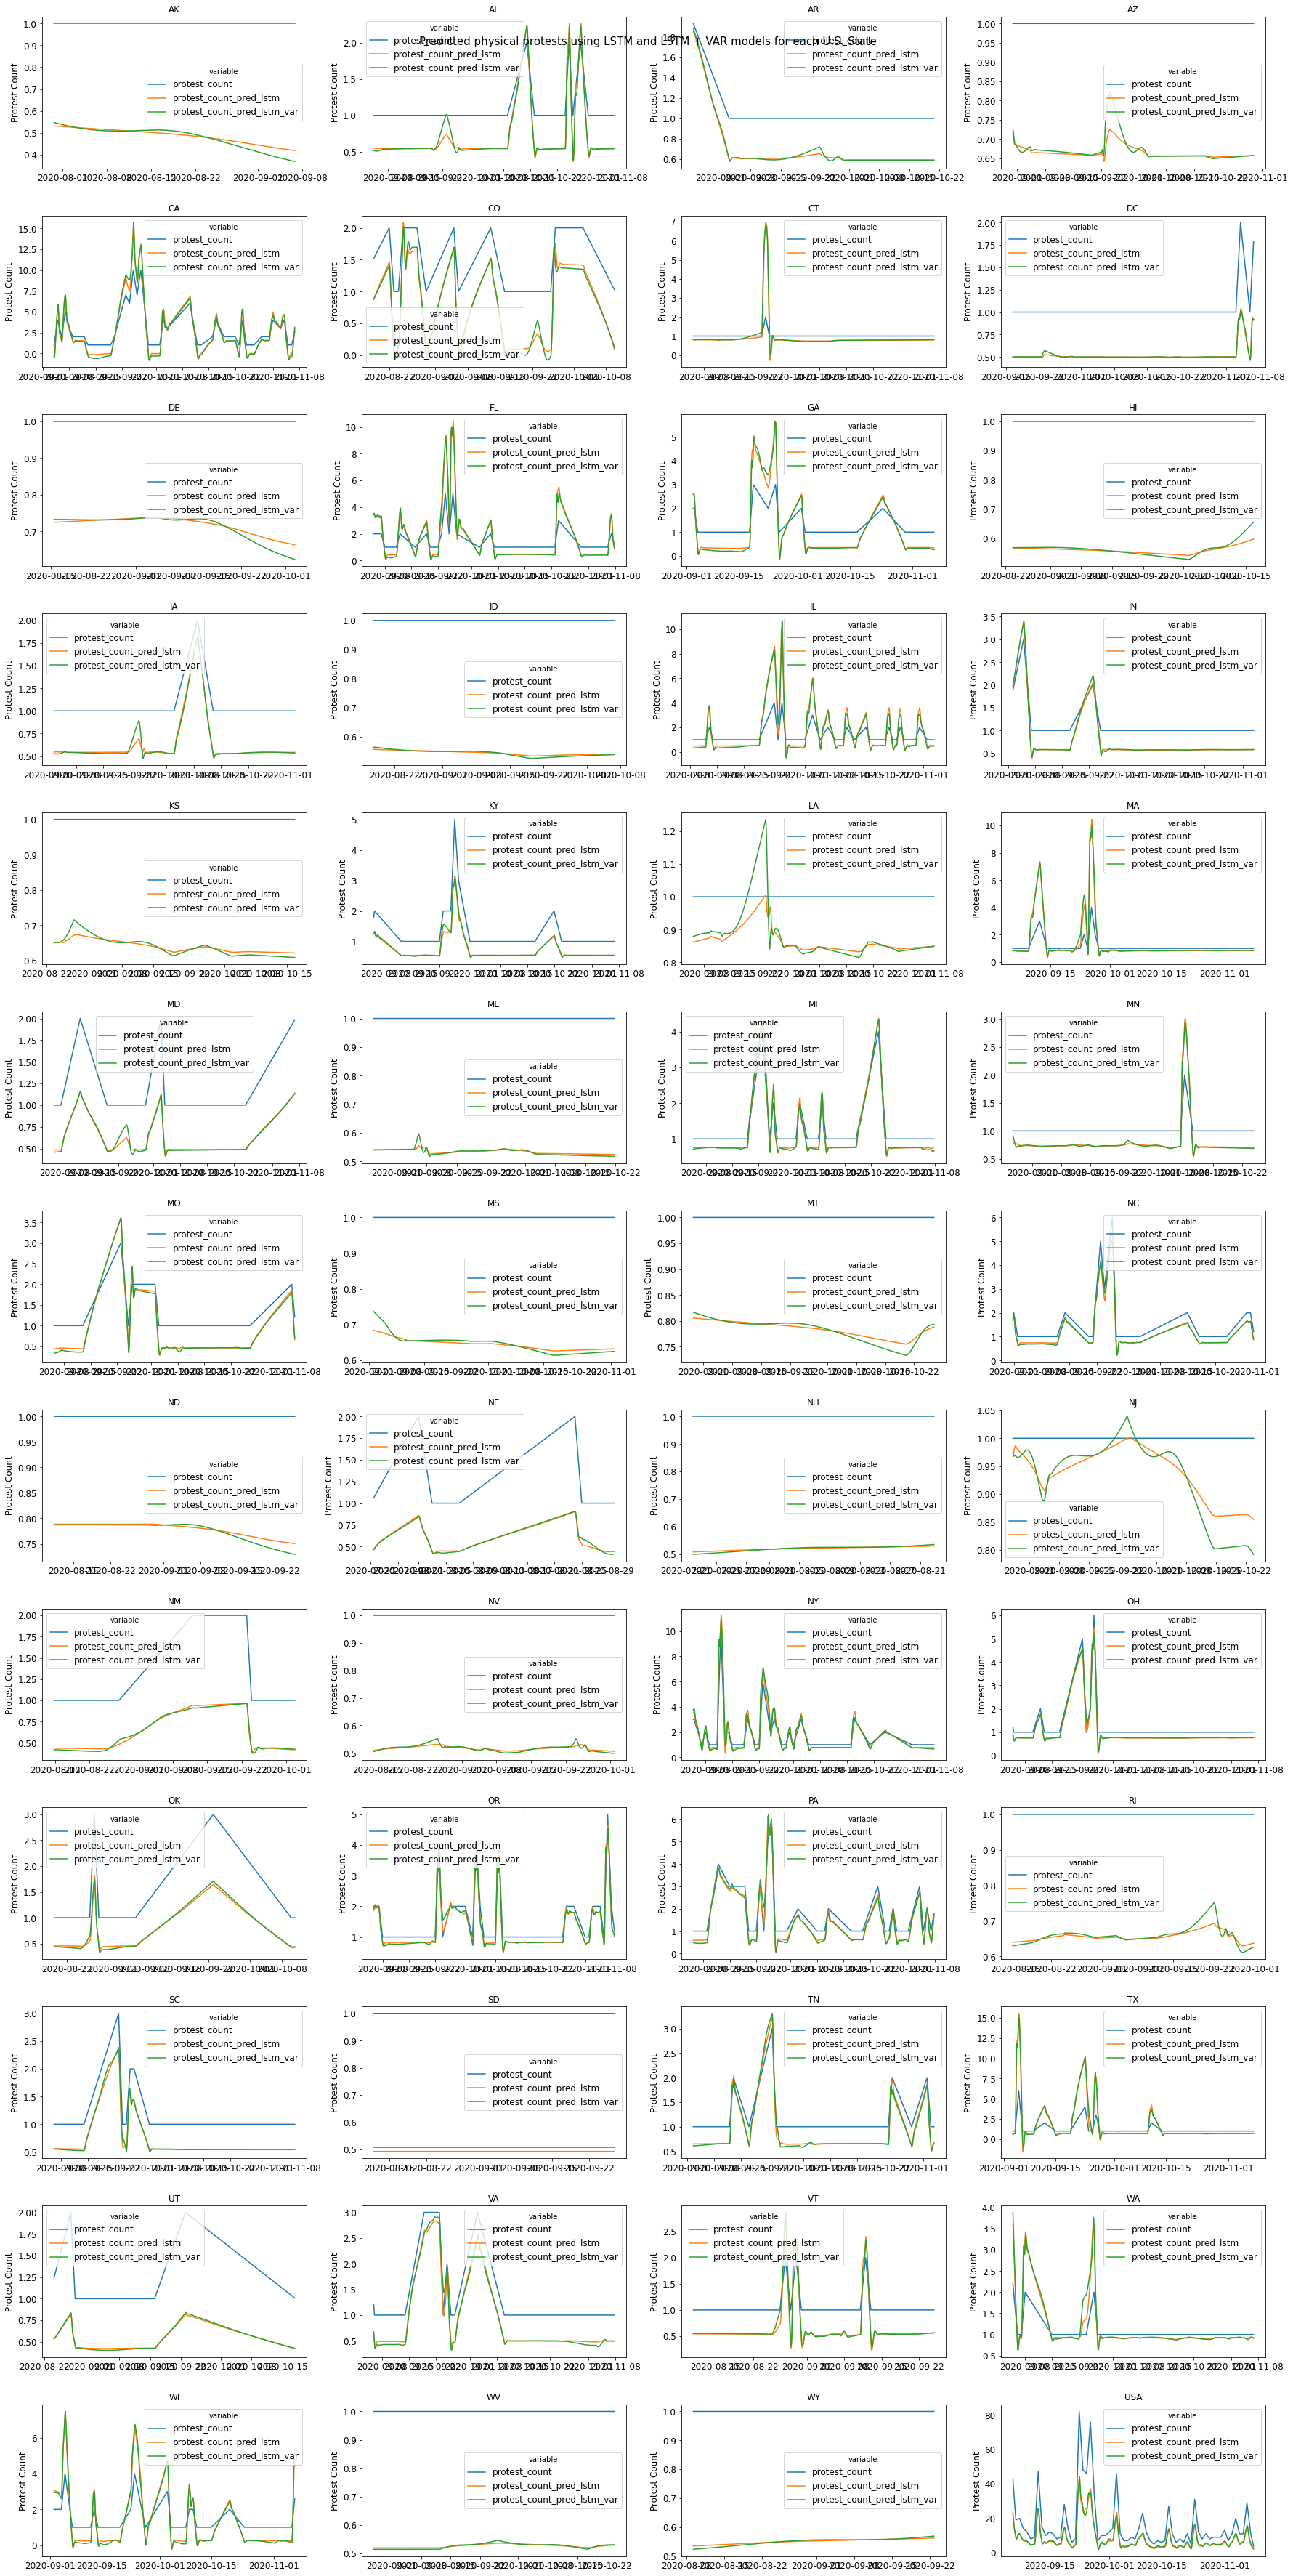

In [1076]:
# fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig, ax = plt.subplots(nrows=13, ncols=4,  figsize=(25,50)) #dpi=150,
plt.suptitle(f"Predicted physical protests using LSTM and LSTM + VAR models for each U.S. State")

ax_num = 0
ax = ax.flatten()
fig.tight_layout(pad=4.0)

for area in df_predictions_state[df_predictions_state['state']!="USA"]['state'].unique():
    
    s_data = df_predictions_long_state[df_predictions_long_state['state']==area]

    # divide predicted values by 2 (dont know why but it works)
    s_data['value'][~s_data['variable'].isin(['tweet_count', 'protest_count'])] = s_data['value'][~s_data['variable'].isin(['tweet_count', 'protest_count'])]/2
    
#     state_pred_tweets = s_data[s_data['variable'].str.contains("tweet")]
    state_pred_prot = s_data[s_data['variable'].str.contains("protest")]
    
#     ax0 = sns.lineplot(data = state_pred_tweets, x = state_pred_tweets.index, y = "value", hue="variable", ax = ax[0])
    ax1 = sns.lineplot(data = state_pred_prot, x = state_pred_prot.index, y = "value", hue="variable", ax = ax[ax_num])
    ax[ax_num].set(xlabel='',ylabel='Protest Count', title=area)
    
#     ax0.set(ylabel = "Tweet Count")
#     ax1.set(ylabel = "Protest Count")
    
    ax_num += 1
    
plt.savefig("../reports/figures/LSTM_VAR_state.PNG", dpi=300)

In [ ]:
plt.savefig("../reports/figures/LSTM_VAR_state.PNG", dpi=300)

In [996]:
### SPLIT TRAIN TEST ###
area = "OR"
state_data = df_rs[df_rs['state']==area][["tweet_count","protest_count"]]

state_train, state_test = train_test_split(state_data, shuffle=False, train_size=0.6)

print(state_train.shape, state_test.shape)

(2391, 2) (1594, 2)


In [988]:
y_train_state = state_train.iloc[best_order:].values
X_train_state = state_train.iloc[best_order:].values 

X_train_state, X_val_state, y_train_state, y_val_state = train_test_split(
    X_train_state, y_train_state, shuffle=False, train_size=0.8)

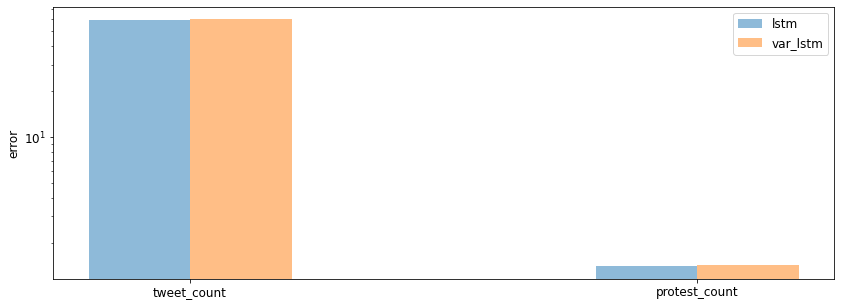

In [989]:
scaler = StandardScaler()
scaler_y = StandardScaler()

y_train_state = scaler_y.fit_transform(y_train_state)

X_test_state = state_test.values
y_test_state = state_test.values

X_test_state = scaler.fit_transform(X_test_state)
X_test_state = create_windows(X_test_state, window_shape = look_back, end_id = -look_ahead)
y_test_state = create_windows(y_test_state, window_shape = look_ahead, start_id = look_back)

pred_lstm_var_state = krs_ft.best_model.predict(X_test_state)
pred_lstm_var_state = scaler_y.inverse_transform(pred_lstm_var_state.reshape(-1, pred_lstm_var_state.shape[-1])).reshape(pred_lstm_var_state.shape)
pred_lstm_state = kgs.best_model.predict(X_test_state)
pred_lstm_state = scaler_y.inverse_transform(pred_lstm_state.reshape(-1, pred_lstm_state.shape[-1])).reshape(pred_lstm_state.shape)

### COMPUTE METRICS ON TEST DATA ###
# TO FINISH
error_lstm_state, error_var_lstm_state = {}, {}
# error_baseline_state = {}

for i,col in enumerate(state_data.columns):
    
    error = mean_squared_error(y_test_state[...,i], pred_lstm_state[...,i])
    error_lstm_state[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test_state[...,i], pred_lstm_var_state[...,i])
    error_var_lstm_state[col] = np.sqrt(error)
    
#     error = mean_squared_error(y_test_state[1:,:,i], np.repeat(y_test_state[:-1,[0],i], look_ahead, axis=1))
#     error_baseline_state[col] = np.sqrt(error)
    
### COMPARE RESULTS ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(error_lstm_state))-0.1, error_lstm_state.values(), 
        alpha=0.5, width=0.2, label='lstm')
plt.bar(np.arange(len(error_var_lstm_state))+0.1, error_var_lstm_state.values(), 
        alpha=0.5, width=0.2, label='var_lstm')
# plt.bar(np.arange(len(error_baseline_state))+0.3, error_baseline_state.values(), 
#         alpha=0.5, width=0.2, label='baseline')
plt.xticks(range(len(error_lstm_state)), error_lstm_state.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)
plt.yscale("log")

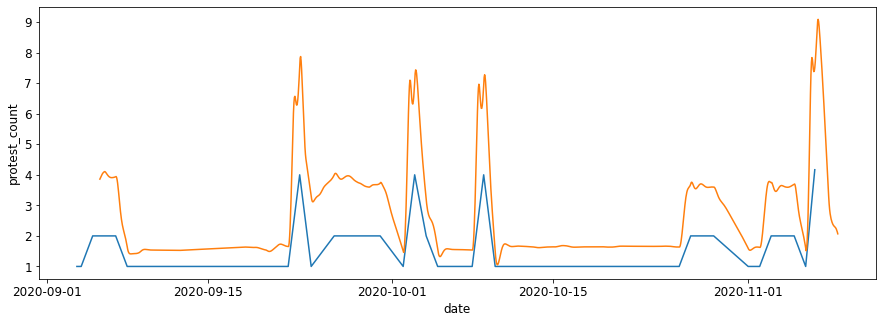

In [990]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x = state_test.iloc[:len(pred_lstm_state[...,1]),:].index, y = state_test.iloc[:len(pred_lstm_state[...,1]),:].protest_count)
ax = sns.lineplot(x = state_test.iloc[look_back_window*2:len(pred_lstm_state[...,1])+look_back_window*2,:].index, y = [d[int(len(d)/2)] for d in pred_lstm_var_state[...,1]])

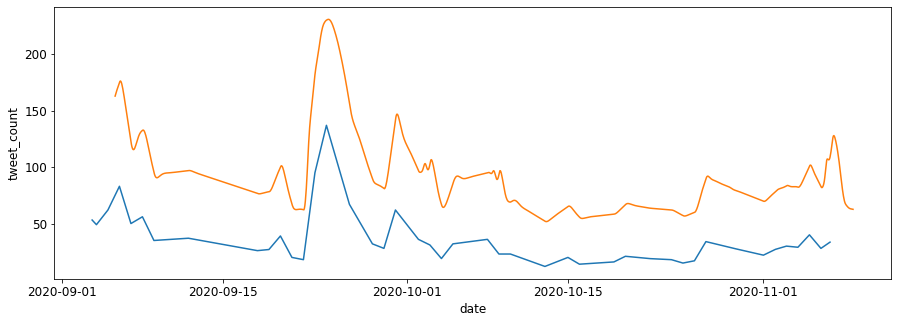

In [986]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x = state_test.iloc[:len(pred_lstm_state[...,1]),:].index, y = state_test.iloc[:len(pred_lstm_state[...,1]),:].tweet_count)
ax = sns.lineplot(x = state_test.iloc[look_back_window*2:len(pred_lstm_state[...,1])+look_back_window*2,:].index, y = [d[int(len(d)/2)] for d in pred_lstm_var_state[...,0]])

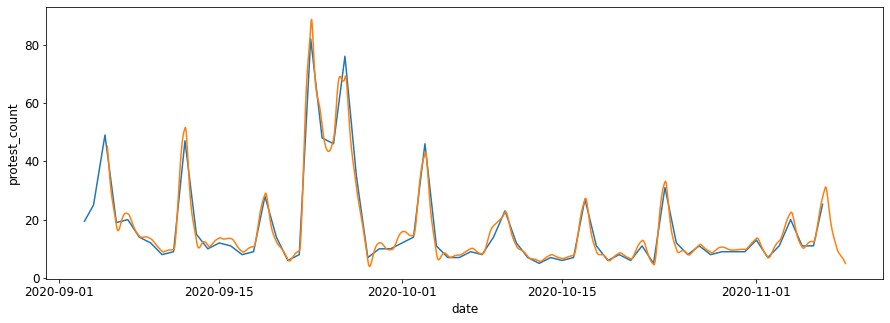

In [883]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x = test.iloc[:1551,:].index, y = test.iloc[:1551,:].protest_count)
ax = sns.lineplot(x = test.iloc[look_back_window*2:1551+look_back_window*2,:].index, y = [d[int(len(d)/2)] for d in pred_lstm_var[...,1]])

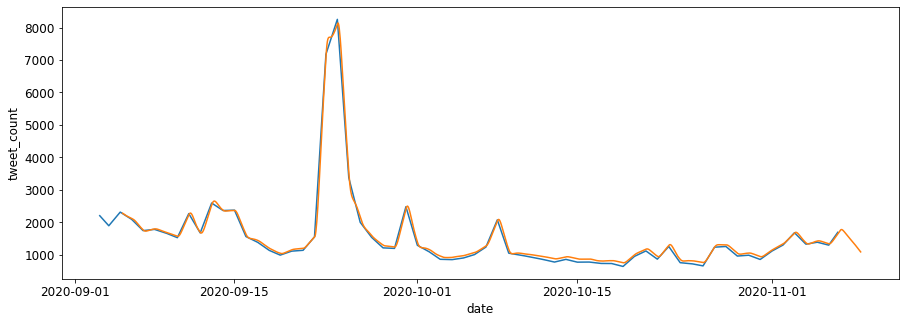

In [876]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x = test.iloc[:1551,:].index, y = test.iloc[:1551,:].tweet_count)
ax = sns.lineplot(x = test.iloc[look_back_window*2:1551+look_back_window*2,:].index, y = [d[int(len(d)/2)] for d in pred_lstm_var[...,0]])

In [816]:
len(y_test[...,1][0])

6

## VAR second try

In [160]:
forecasting_model = VAR(df_train)
results_aic = []
for p in range(1,10):
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)

C:\Users\Leonardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


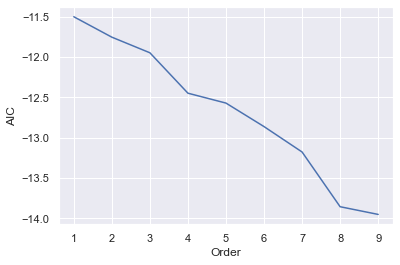

In [163]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [164]:
results = forecasting_model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 12, Jun, 2021
Time:                     04:18:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.3842
Nobs:                     157.000    HQIC:                  -11.4535
Log likelihood:           463.279    FPE:                1.01204e-05
AIC:                     -11.5010    Det(Omega_mle):     9.74446e-06
--------------------------------------------------------------------
Results for equation tweet_count
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.004755         0.005005            0.950           0.342
L1.tweet_count           0.973767         0.053279           18.277           0.000
L1.protest_count        -0.020391         

In [166]:
laaged_values = df_train.values[-1:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = df_test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

realgdp_1d  realdpi_1d
date                              
2020-10-31    0.030260    0.005102
2020-11-01    0.034116    0.005103
2020-11-02    0.037872    0.007383
2020-11-03    0.041482    0.010442
2020-11-04    0.044936    0.013703
2020-11-05    0.048232    0.016945
2020-11-06    0.051376    0.020087
2020-11-07    0.054373    0.023102
2020-11-08    0.057230    0.025984
2020-11-09    0.059954    0.028734

df

### Multivariate LSTM Forecast Model

### 1. Prepare data for modelling
We will frame the supervised learning problem as predicting the number of physical protests at the current day (t) given the number of physical protests and number of tweets at the prior time step.

In [174]:
# tweets_geo = gpd.read_file("../data/raw/processed/tweets_gdf_fs.geojson")
# protest data
# df_p = pd.read_excel("../data/raw/protests/USA_2020_2021_Feb12.xlsx")
# df_p['protest_count'] = 1
# df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'])
# df_p = df_p[(df_p['ASSOC_ACTOR_1'] == "BLM: Black Lives Matter")&(df_p['EVENT_DATE'] > "2020-05-25")]

In [295]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM

 
# load dataset
dataset = df_p_t.iloc[:,3:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = DataFrame(scaler.fit_transform(values))
scaled.columns = dataset.columns
# # frame as supervised learning
# reframed = series_to_supervised(scaled, 1, 1)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
scaled.head(10)

tweet_count  protest_count  protest_count_lag1  protest_count_lag2  \
0     0.045669       0.009646                 NaN                 NaN   
1     0.199820       0.020900            0.009646                 NaN   
2     0.370030       0.070740            0.020900            0.009646   
3     0.541355       0.221865            0.070740            0.020900   
4     0.585227       0.588424            0.221865            0.070740   
5     0.817652       0.744373            0.588424            0.221865   
6     0.799336       0.604502            0.744373            0.588424   
7     1.000000       0.673633            0.604502            0.744373   
8     0.727213       0.588424            0.673633            0.604502   
9     0.600196       0.508039            0.588424            0.673633   

   protest_count_lag3  protest_count_lag4  protest_count_lag5  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3            0.009646                 NaN                 NaN   
4            0.020900            0.009646                 NaN   
5            0.070740            0.020900            0.009646   
6            0.221865            0.070740            0.020900   
7            0.588424            0.221865            0.070740   
8            0.744373            0.588424            0.221865   
9            0.604502            0.744373            0.588424   

   protest_count_lag6  protest_count_lag7  tweet_count_lag1  tweet_count_lag2  \
0                 NaN                 NaN               NaN               NaN   
1                 NaN                 NaN          0.045669               NaN   
2                 NaN                 NaN          0.199820          0.045669   
3                 NaN                 NaN          0.370030          0.199820   
4                 NaN                 NaN          0.541355          0.370030   
5                 NaN                 NaN          0.585227          0.541355   
6            0.009646                 NaN          0.817652          0.585227   
7            0.020900            0.009646          0.799336          0.817652   
8            0.070740            0.020900          1.000000          0.799336   
9            0.221865            0.070740          0.727213          1.000000   

   tweet_count_lag3  tweet_count_lag4  tweet_count_lag5  tweet_count_lag6  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3          0.045669               NaN               NaN               NaN   
4          0.199820          0.045669               NaN               NaN   
5          0.370030          0.199820          0.045669               NaN   
6          0.541355          0.370030          0.199820          0.045669   
7          0.585227          0.541355          0.370030          0.199820   
8          0.817652          0.585227          0.541355          0.370030   
9          0.799336          0.817652          0.585227          0.541355   

   tweet_count_lag7  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
5               NaN  
6               NaN  
7          0.045669  
8          0.199820  
9          0.370030

In [299]:
# split into train and test sets
p_lag = ""
t_lag = "" #"_lag1"
values = scaled[[f'tweet_count{t_lag}', f'protest_count{p_lag}']].values
n_train_days = 100
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(f"Training: \tX.shape: {train_X.shape}, \tY.shape: {train_y.shape}")
print(f"Validation:\tX.shape: {test_X.shape}, \tY.shape: {test_y.shape}")

(100, 1, 1) (100,) (68, 1, 1) (68,)
Training: 	X.shape: (100, 1, 1), 	Y.shape: (100,)
Validation:	X.shape: (68, 1, 1), 	Y.shape: (68,)


In [270]:
# scaled[[f'tweet_count{t_lag}', f'protest_count{p_lag}']]

In [248]:
# train_X

### 2. Define and Fit Model
Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [283]:
# Function for model creation
# def FNNmodel(n_hidden_neurons=10, dropout_rate=0.1):
#   i = Input(shape=(T,))      
#   x = Dense(neurons, activation='sigmoid', name='Hidden_layer')(i)
#   x = Dropout(dropout_rate)(x)
#   x = Dense(1, activation='sigmoid', name='Output')(x)  
#   model = Model(i,x)
#   return model

def RNNmodel(n_hidden_neurons=10, cell_type='LSTM', dropout_rate=0.2):
    i = Input(shape=(train_X.shape[1], train_X.shape[2]))
    if cell_type == 'SimpleRNN':
        x = SimpleRNN(n_hidden_neurons, activation='tanh', return_sequences=False, name='SimpleRNN')(i)
    elif cell_type == 'LSTM':
        x = LSTM(n_hidden_neurons, activation='tanh', name='LSTM')(i)
    else:
        raise Exception("Error: Cell type not recognized! Choose between 'SimpleRNN','LSTM', or 'GRU'.")    
    x = Dropout(dropout_rate)(x)
    x = Dense(1, activation='sigmoid', name='Output')(x)
    model = Model(i,x)
    return model

In [278]:
train_X.shape[0], train_X.shape[1]

(100, 1)

In [227]:
Input(shape=(train_X.shape[0], train_X.shape[1]))

<tf.Tensor 'input_7:0' shape=(None, 100, 1) dtype=float32>

In [284]:
# ANN_type = ['SimpleRNN','LSTM']
# neurons = [10,25]
# dropout_rate = [0,0.25]
lr = 0.0001#[0.0001]
# batch_size = [16]

# all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,lr,batch_size]))
# print(pd.DataFrame(data=all_combinations, columns=['ann_type','neurons','dropout_rate','lr','batch_size']))
# model = RNNmodel(neurons, cell_type=ANN_type, dropout_rate=dropout_rate)
model = RNNmodel(50, cell_type="LSTM", dropout_rate=0)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [304]:
import tensorflow
tensorflow.keras.backend.clear_session()
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [1]:
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
# pyplot.plot(history.history['accuracy'], label='train')
# pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'model' is not defined

In [187]:
# scaled[[f'tweet_count{lag}', f'protest_count{lag}']]